In [1]:
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from math import *

import scipy as sp
import scipy.optimize

In [2]:
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

def circles(x, y, s, c='b', **kwargs):
    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
        
    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

In [74]:
def to_xyz(array):
    alpha, r, h = array
    return np.array([array[1] * np.cos(array[0]), array[1] * np.sin(array[0]), h])

def generate_points(size, min_d, max_d):
    if not size:
        return np.zeros((size, 4))
    
    ds = np.random.uniform(min_d, max_d, [size, 1])

    hs = np.random.uniform(ds * 0.5, H - ds * 0.5, [size, 1])# * 0 + H / 2
    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    rs = (R - ds * 0.5) * np.sqrt(np.random.uniform(0, 1, [size, 1]))# // 2
    
    coords = np.apply_along_axis(to_xyz, 1, np.hstack([alphas, rs, hs]))
    
    return np.hstack([coords, ds])

def generate_population(obsticles, population_size, min_prob=0):
    population = generate_points(population_size, MIN_D, MAX_D)
    bad = filter_collisions(population, obsticles)
    population = population[np.logical_not(bad)]
    prob = sum(np.logical_not(bad)) / len(bad)

    if prob < min_prob:
        return None
    
    while population.shape[0] < population_size:
        need = population_size - population.shape[0]
        estimated = ceil(1.1 * need / prob)
        
        beings = generate_points(estimated, MIN_D, MAX_D)
        bad = filter_collisions(beings, obsticles)
        beings = beings[np.logical_not(bad)]
        population = np.vstack([population, beings[:need]])
    
    return population, prob
        
def generate_population_obsticles(population_size, obsticles_count, min_prob=0):
    obsticles = generate_points(obsticles_count, O_MIN_D, O_MAX_D)
    population, _ = generate_population(obsticles, population_size, min_prob)
    return population, obsticles

def generate_displacement(population, delta_t):
    sigmas = np.sqrt(2 * preD / population[:, N] * delta_t)
    return np.random.randn(population.shape[0], population.shape[1] - 1) * sigmas[:, np.newaxis]

def check_for_out_of_bounds(population):
    first = population[:, N] <= population[:, N - 1]
    second = population[:, N - 1] <= H - population[:, N]
    third = np.linalg.norm(population[:, :N - 1], axis=1) <= R - population[:, N]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

def check_for_collisions_being(being, obsticles):
    return np.linalg.norm(obsticles[:, :N] - being[:N], axis=1) ** 2 < (obsticles[:, N] + being[N]) ** 2
    
def check_for_collisions_obsticle(obsticle, population):
    return np.linalg.norm(population[:, :N] - obsticle[:N], axis=1) ** 2 < (population[:, N] + obsticle[N]) ** 2

# def filter_collisions(population, obsticles):
#     return np.any(np.apply_along_axis(check_for_collisions, 1, population, obsticles), axis=1)

def filter_collisions(population, obsticles):
    if population.shape[0] > obsticles.shape[0]:
        return np.any(np.apply_along_axis(check_for_collisions_obsticle, 1, obsticles, population), axis=0)
    else:
        return np.any(np.apply_along_axis(check_for_collisions_being, 1, population, obsticles), axis=1)

def build_tracks(population, obsticles, length):
    tracks = np.zeros([population.shape[0], length, N])
    
    for i in range(length):
        tracks[:, i, :] = population[:, :N]
    
        deltas = generate_displacement(population, DELTA_T)
        population[:, :N] += deltas
        need_to_revert = np.logical_or(check_for_out_of_bounds(population), filter_collisions(population, obsticles))
#         need_to_revert = check_for_out_of_bounds(population)
        population[:, :N][need_to_revert] -= deltas[need_to_revert]
        
    return tracks

def remove_same(track):
    indexes = np.hstack([[True], np.any(track[1:, :] != track[:-1, :], axis=1)]) 
    return track[indexes]

N = 3
ETA = 1.0e-3
kB = 1.38e-23
T = 293

preD = kB * T / (3 * np.pi * ETA)

MIN_D = 1e2 * 1e-9
MAX_D = MIN_D#3e2 * 1e-9
O_MIN_D = 16 * MAX_D * 1
O_MAX_D = 16 * MAX_D * 1
R = 10 * 1e-6
H = MIN_D * 3#1.5 * 1e-5

MAX_D_COEF = preD / MIN_D
DELTA_T = R**2 / (2 * (N - 1) * MAX_D_COEF) / 10000
# DELTA_T = 0

PART_CNT = 1000
OBST_CNT = 100
TRACK_SIZE = 100

# start_time = time.time()
# population, obsticles = generate_population_obsticles(PART_CNT, OBST_CNT)
# end_time = time.time()
# print('{} to generate {} population with {} obsticles'
#       .format(end_time - start_time, len(population), len(obsticles)))

# start_time = time.time()
# tracks = build_tracks(population, obsticles, TRACK_SIZE)
# end_time = time.time()

# print('{} to simulate {} partitions with {} obsticles'
#       .format(end_time - start_time, PART_CNT, OBST_CNT))

# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca()
# ax.add_artist(plt.Circle((0, 0), R, color='b'))
# for obsticle in obsticles:
#     ax.add_artist(plt.Circle(obsticle[:N-1], obsticle[N]))
# for (i, track) in enumerate(tracks):
#     ax.plot(track[:, 0], track[:, 1])
# #     if i > 100:
# #         break
# plt.savefig('./presentation/model.pdf')
# plt.show()
# calculate_fitness(obsticles, visualize=True)

In [78]:
from operator import itemgetter

def t_function(x, alpha, beta):
    return beta * x ** alpha

def prob_penalty(prob):
    return 0 if prob > 0.15 else 1 if prob < 0.1 else 1 - (prob - 0.1) / (0.15 - 0.1)

def calculate_fitness(obsticles, visualize=False):
    population, prob = generate_population(obsticles, PART_CNT, 0.05)
    if population is None:
        return float('Inf')
    tracks = build_tracks(population, obsticles, TRACK_SIZE)

    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) 
              for i in range(0, tracks[0].shape[0])]
    xs = np.arange(len(ys))
    popt, _ = sp.optimize.curve_fit(t_function, xs, ys, [1, 1])
    
    if visualize:
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(xs, ys)
        ax1.plot(xs, t_function(xs, *popt))
        
        ax2 = fig.add_subplot(1, 2, 2)
        circles(0, 0, R, c='b')
        for obsticle in obsticles:
            circles(*obsticle[:N-1], obsticle[N], c='r')
        for (i, track) in enumerate(tracks):
            ax2.plot(track[:, 0], track[:, 1])
        plt.show()
        
    return popt[0] + prob_penalty(prob)

3


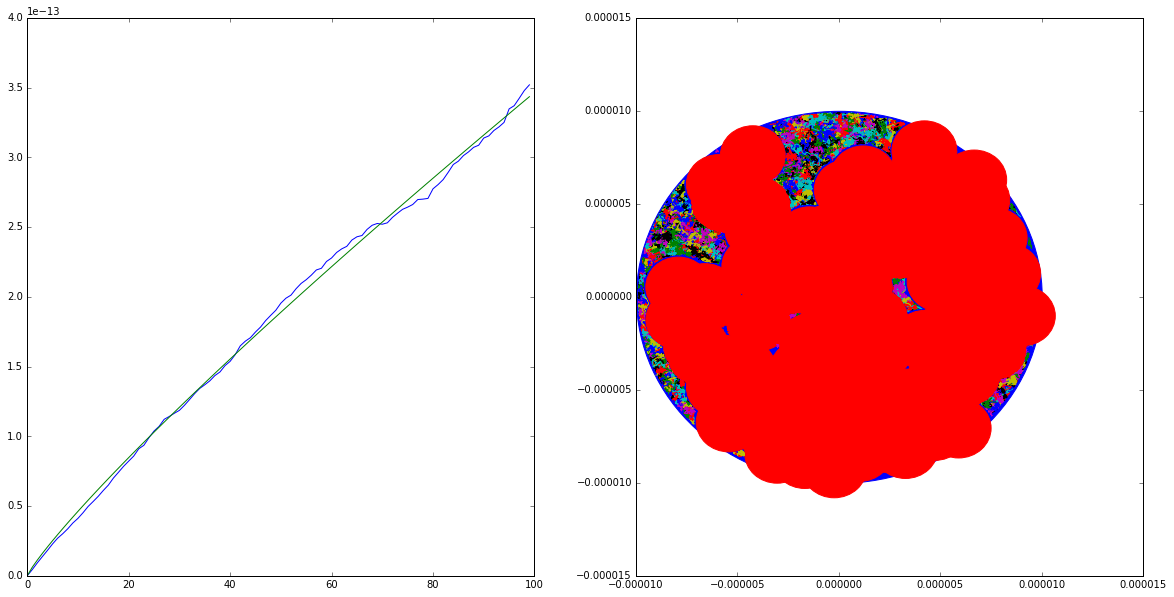

Best fitness: 1.7752524366459377
9


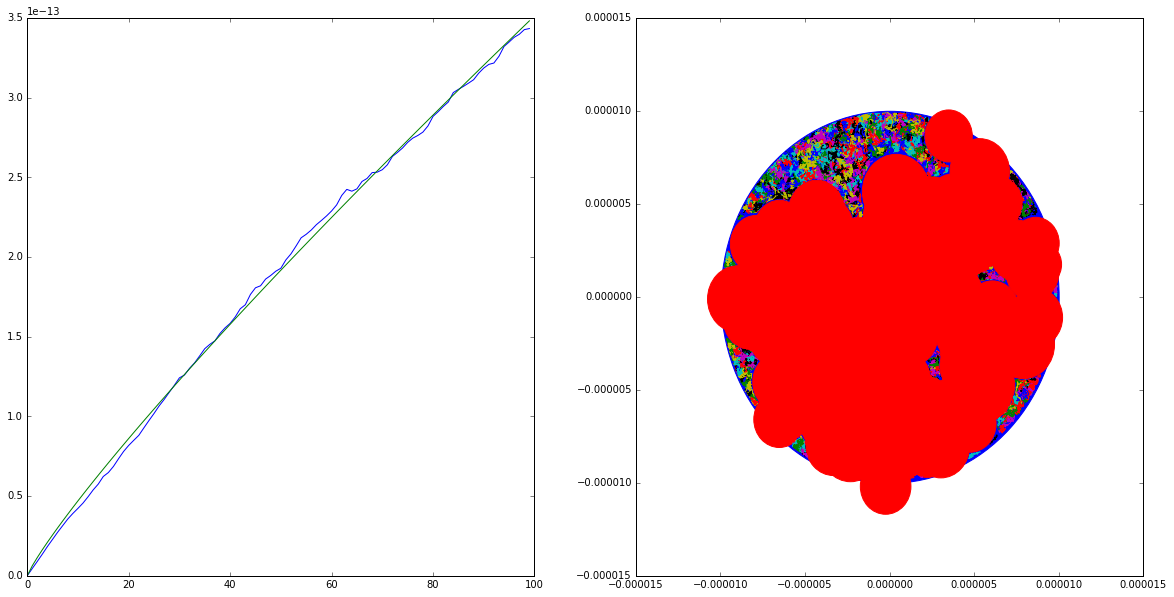

Best fitness: 1.2735644105556427
9


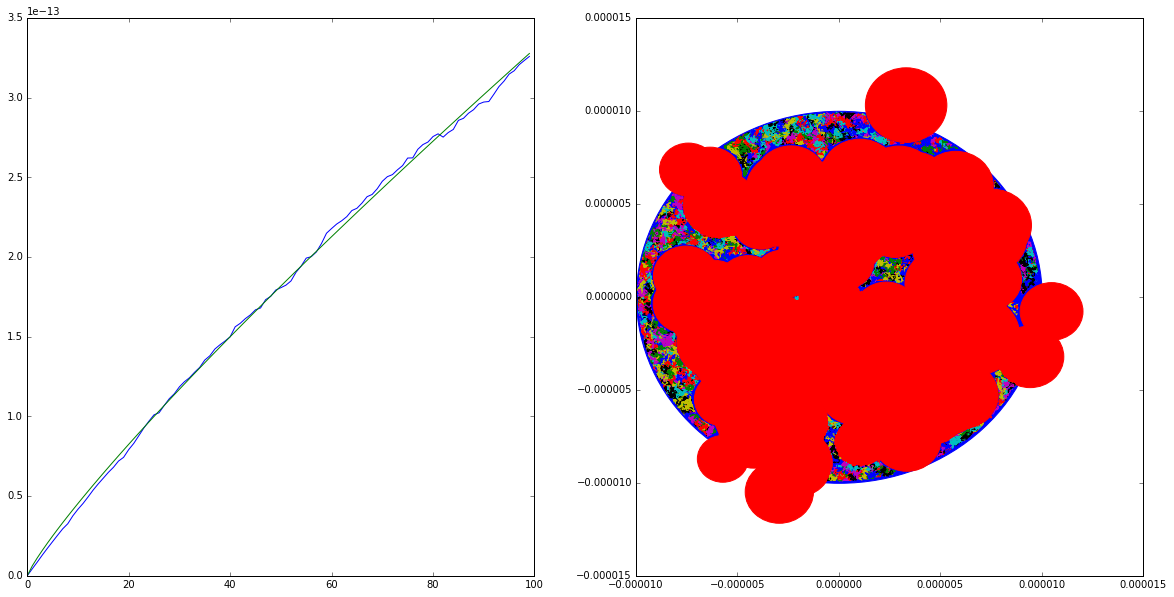

Best fitness: 1.1226605736884343
9


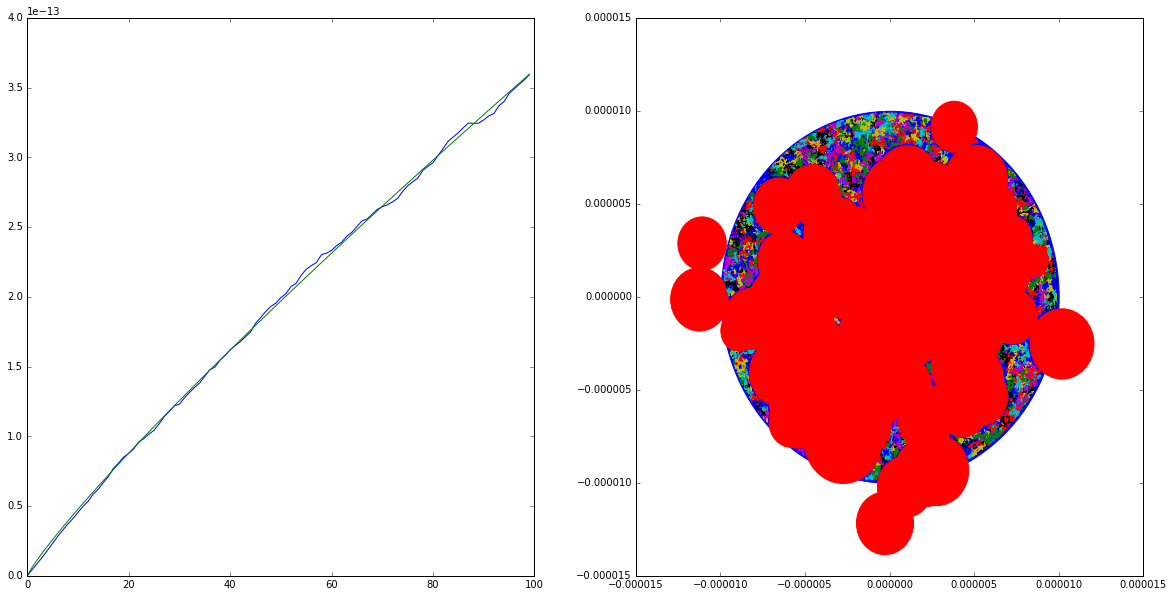

Best fitness: 0.8810950201329966
9


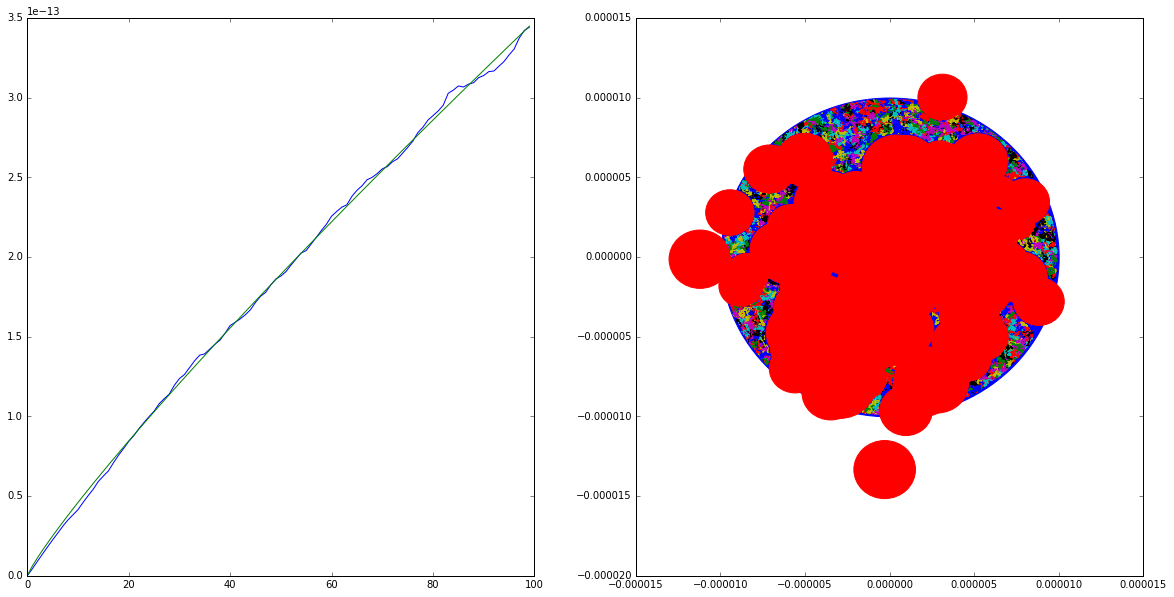

Best fitness: 0.8790728492470846
9


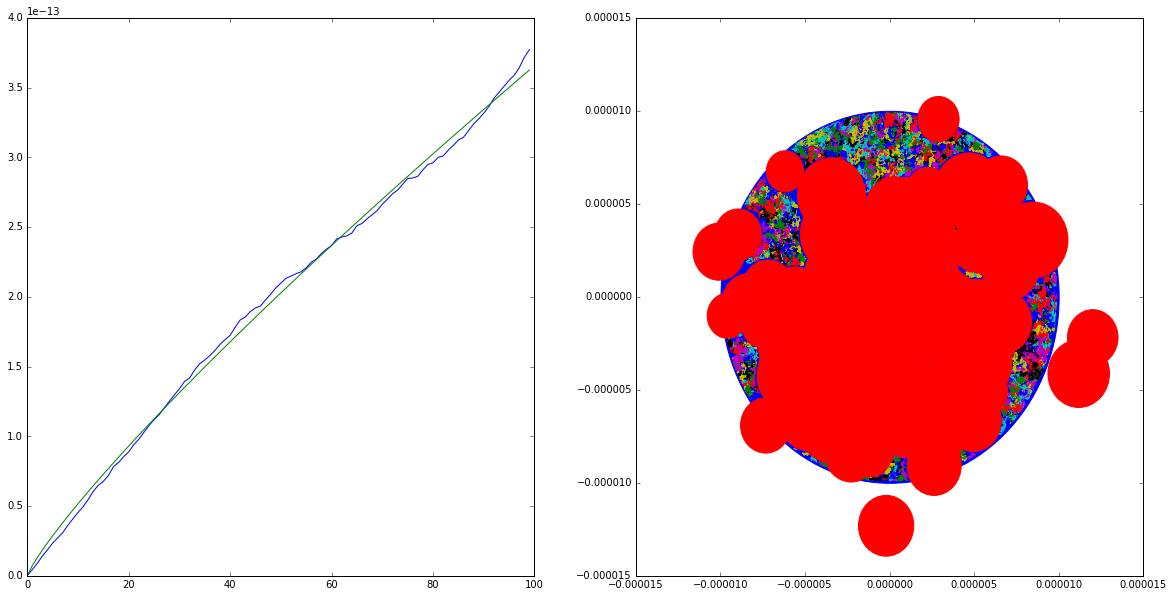

Best fitness: 0.8509693493820956
9


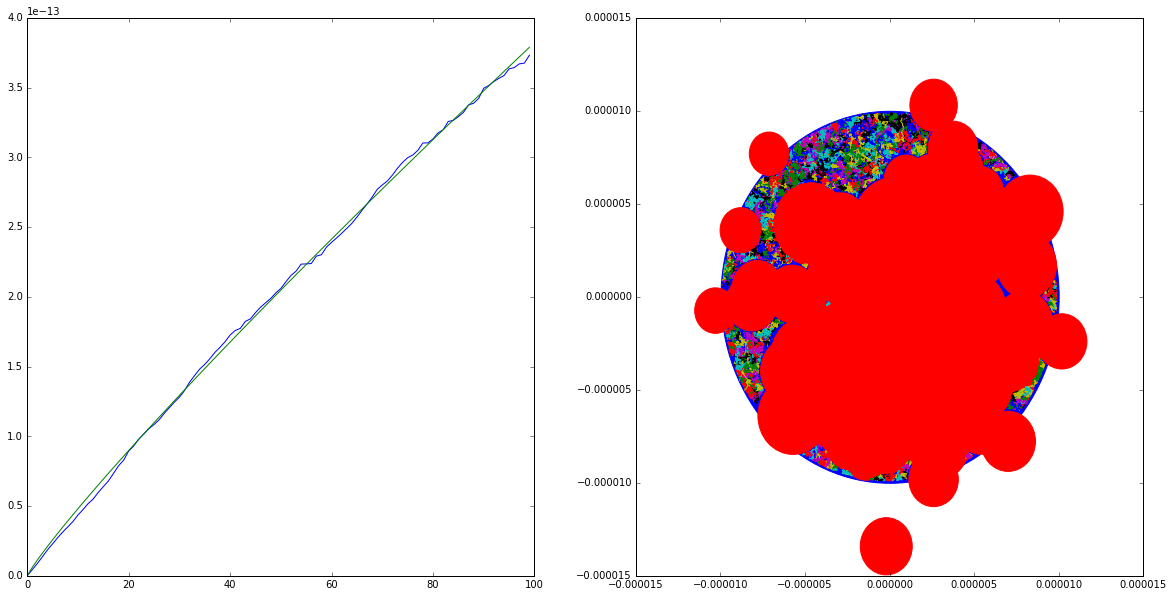

Best fitness: 0.9203569416632512
9


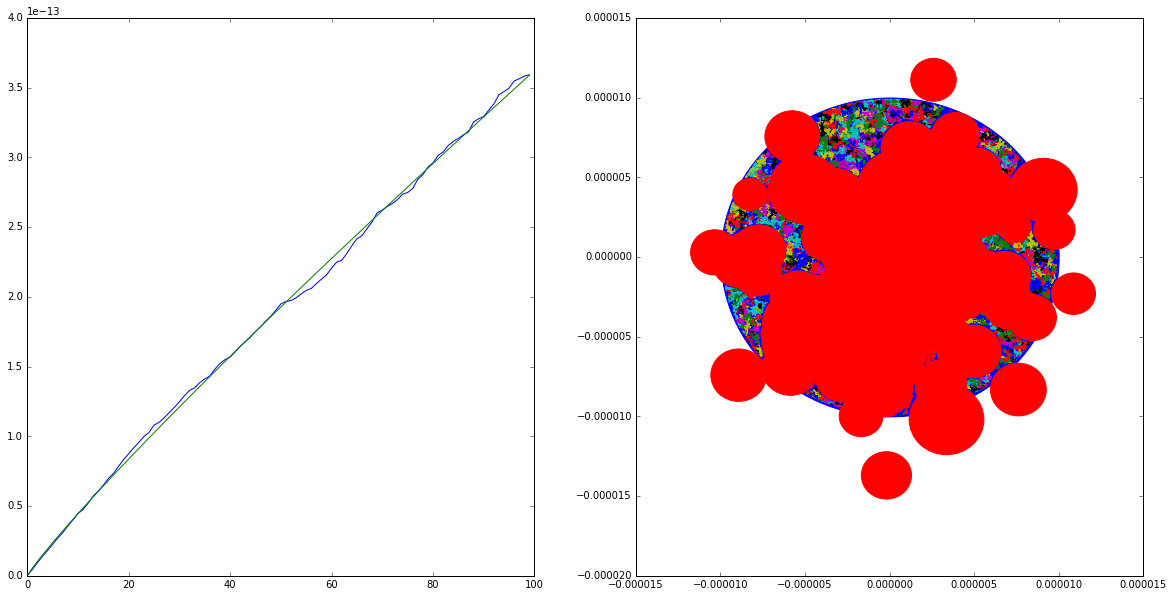

Best fitness: 0.9102786212147874
9


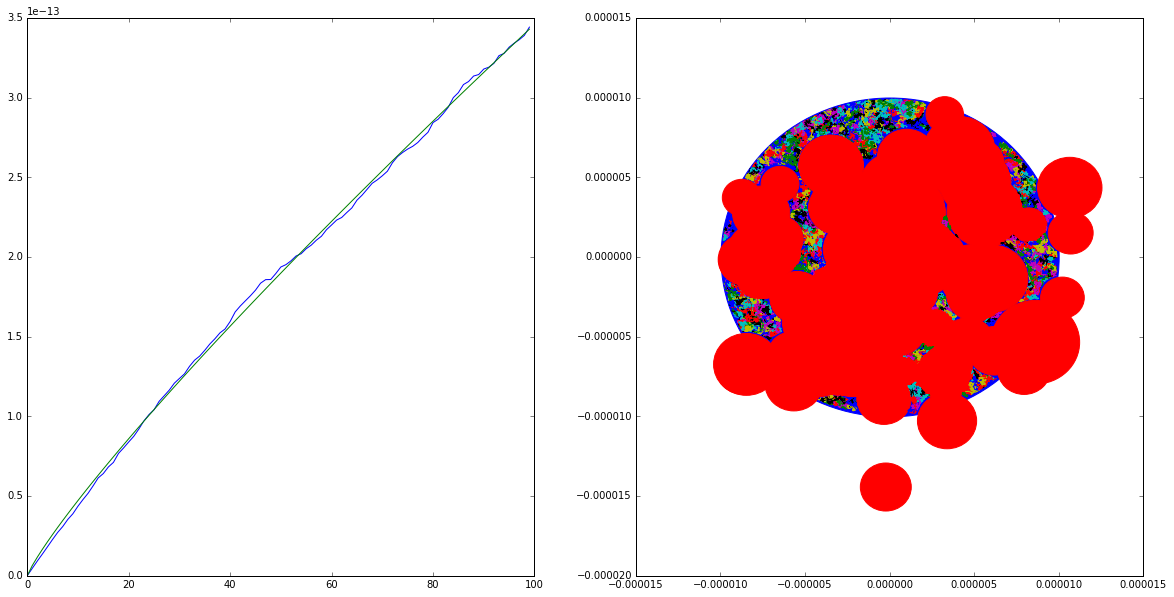

Best fitness: 0.8652006776468838
9


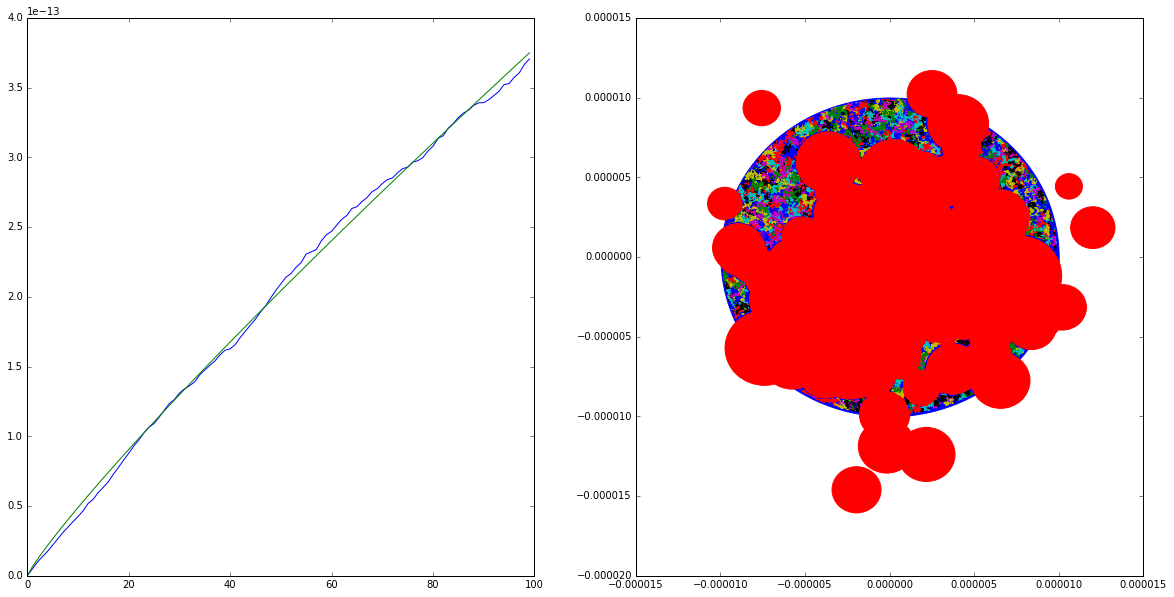

Best fitness: 0.888600148471878
9


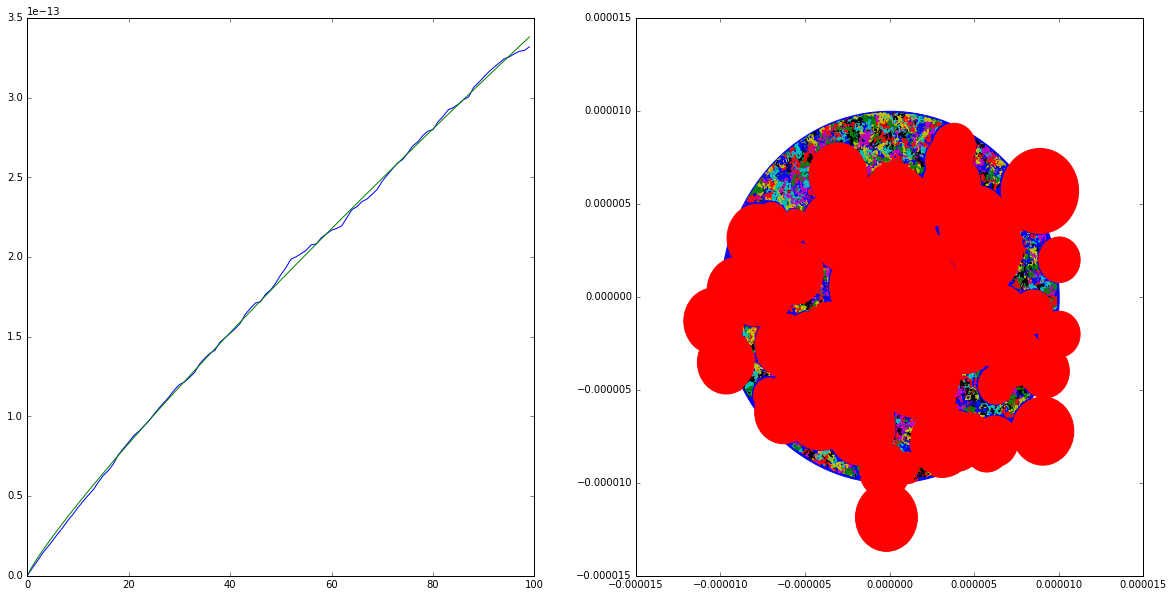

Best fitness: 0.8783620702285485
9


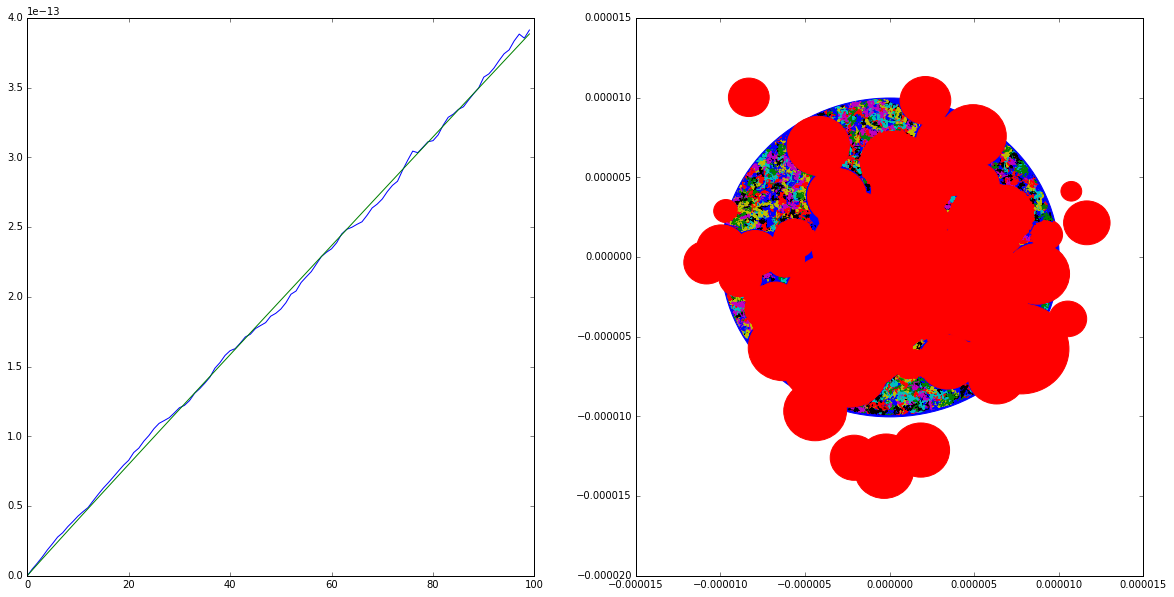

Best fitness: 0.9890817970713207
9


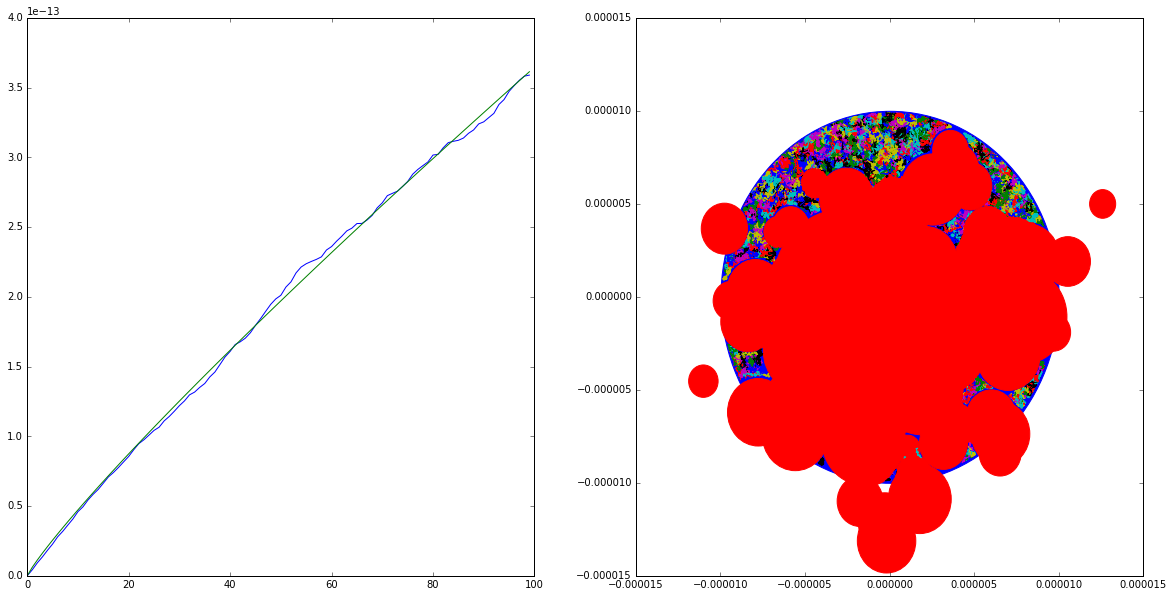

Best fitness: 0.8875619962347708
9


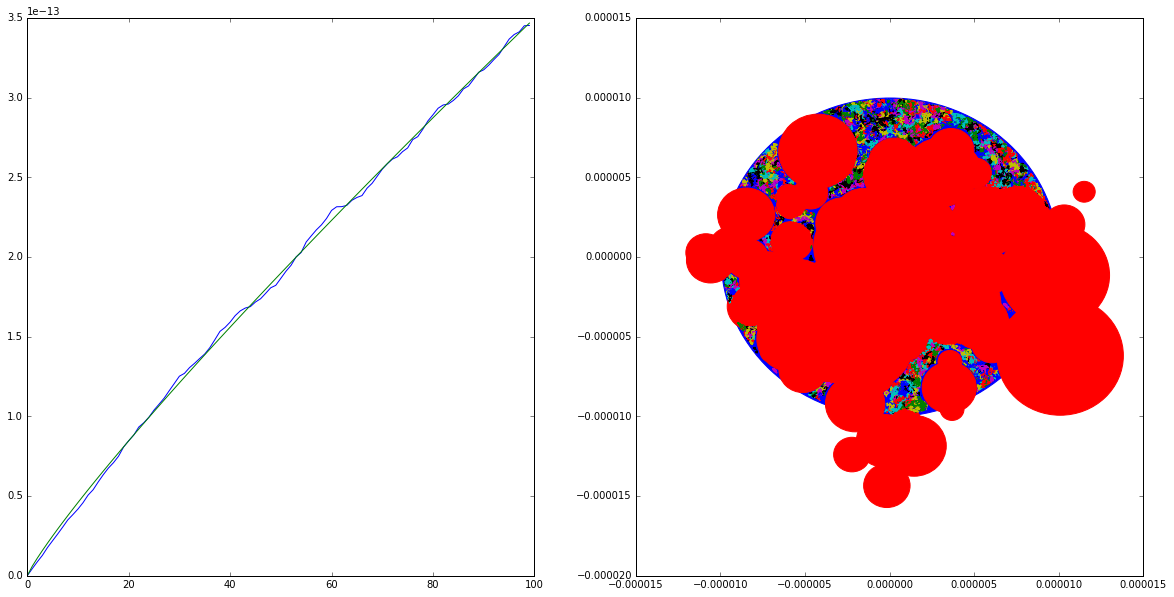

Best fitness: 0.8816478532569678
9


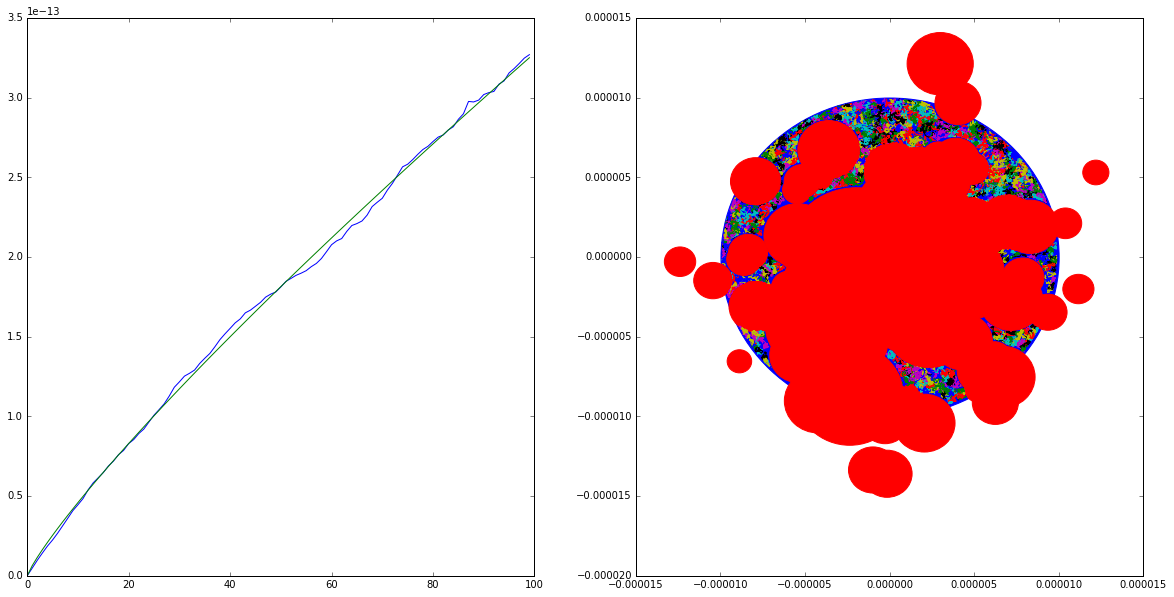

Best fitness: 0.8536716881723376
9


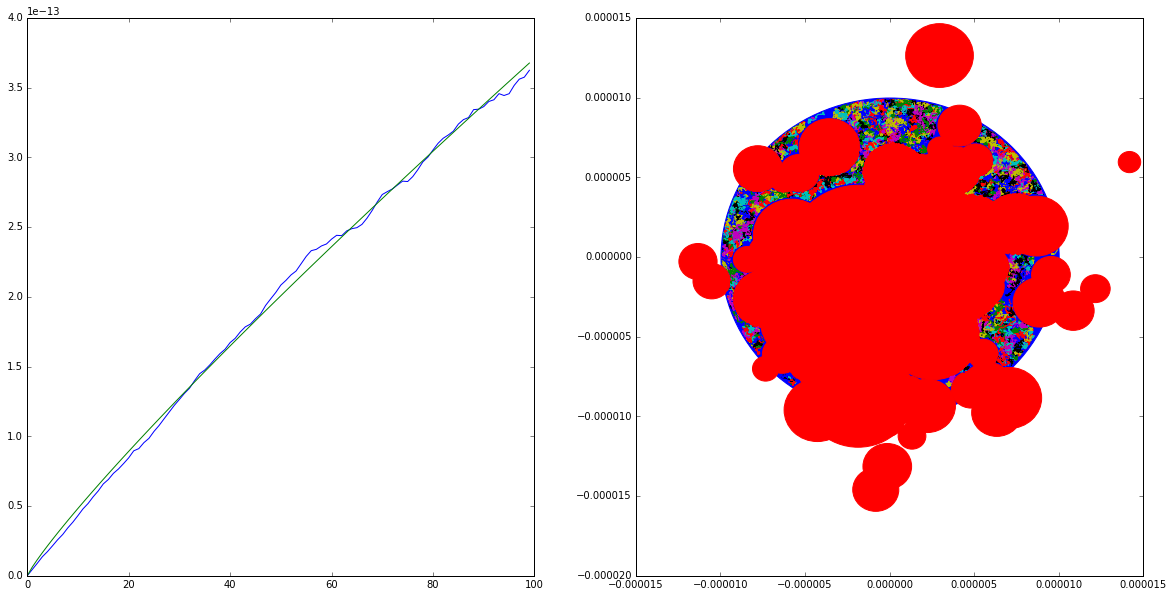

Best fitness: 0.8854606091790465
9


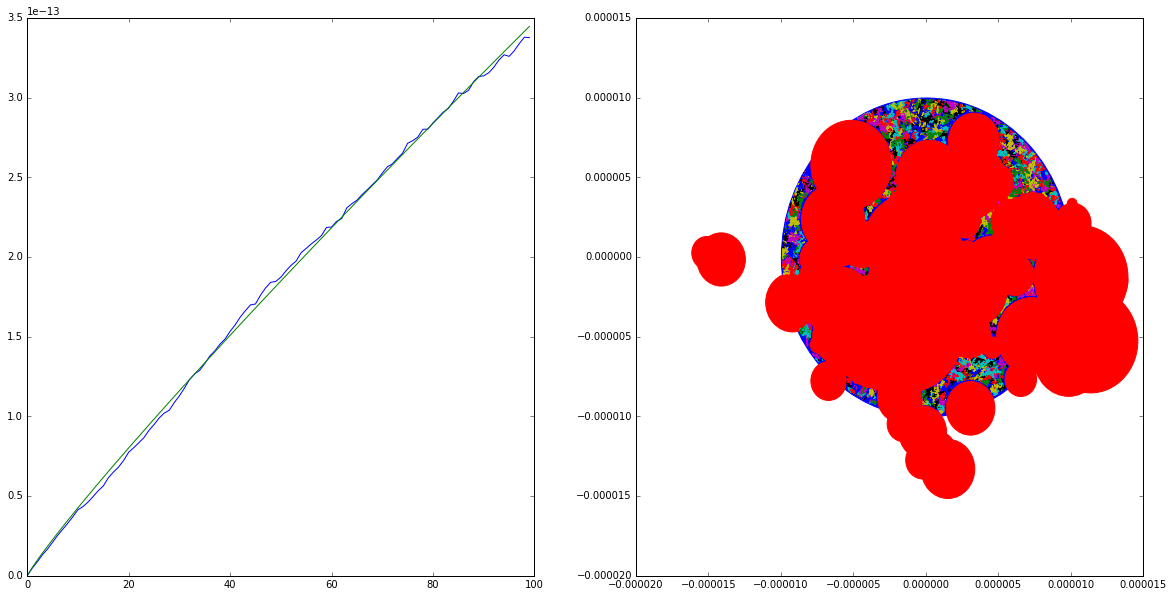

Best fitness: 0.9115878295853023
9


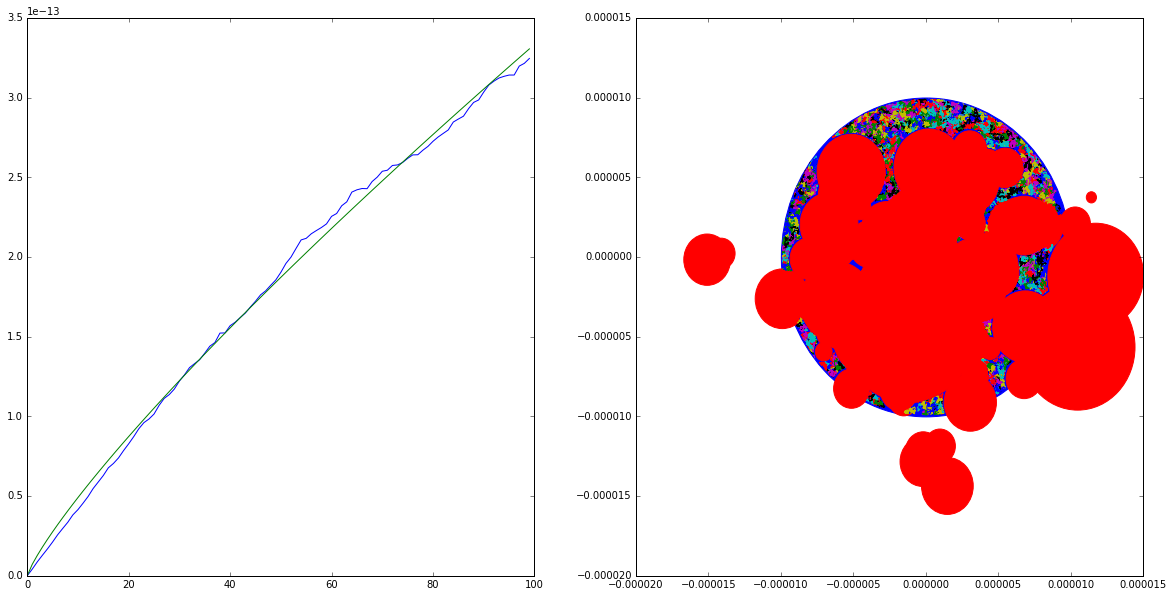

Best fitness: 0.8321296550543048
9


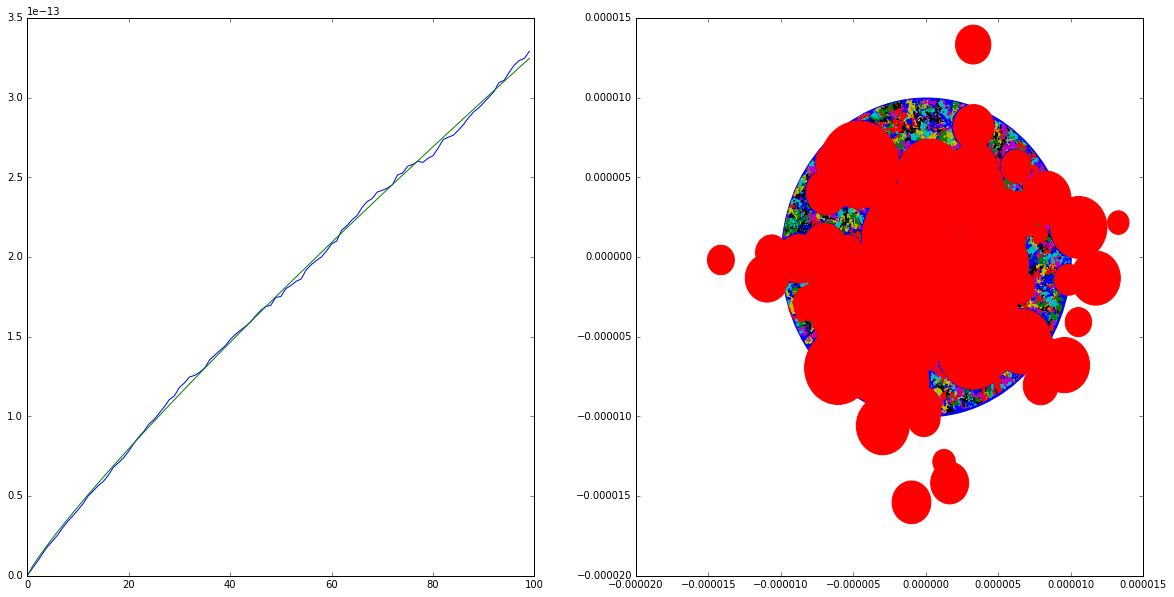

Best fitness: 0.8784271265848492
9


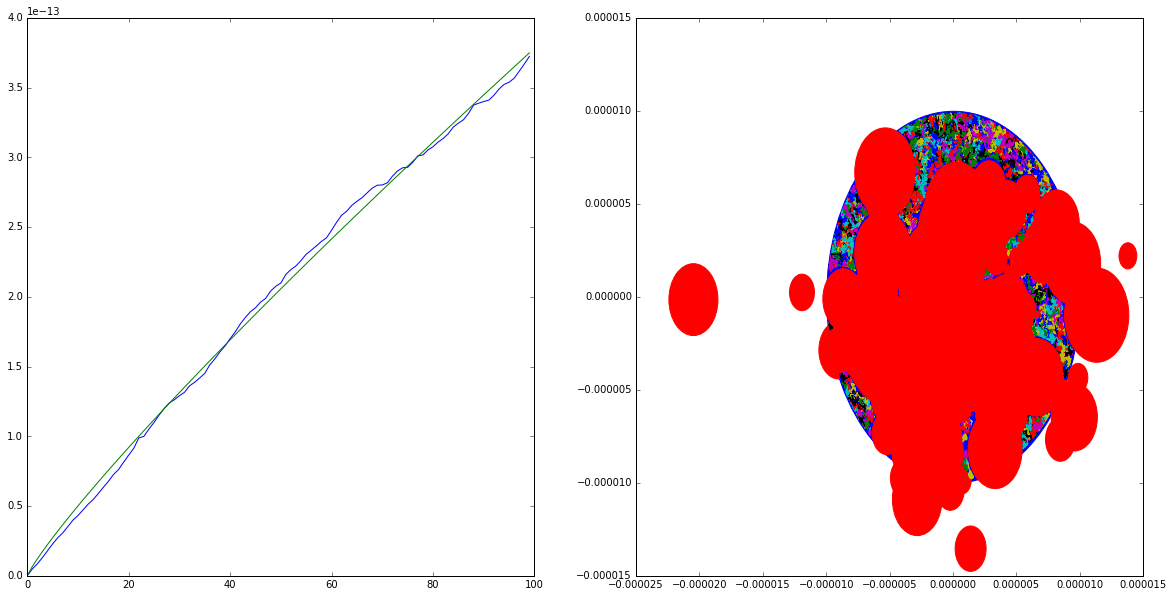

Best fitness: 0.878368990714514
9


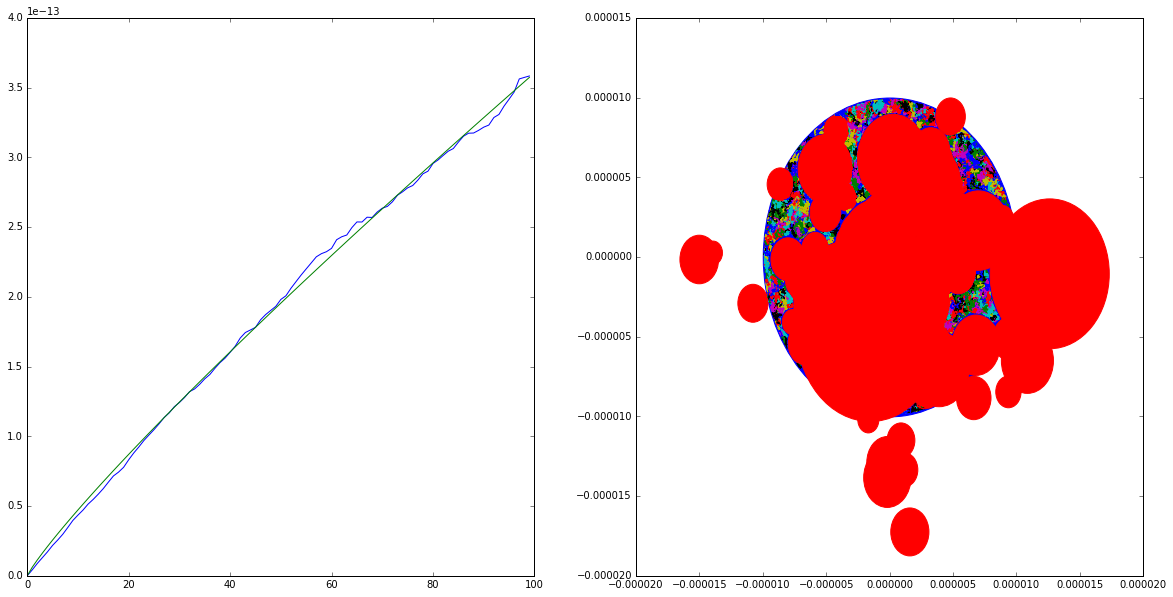

Best fitness: 0.8829888893687631
9


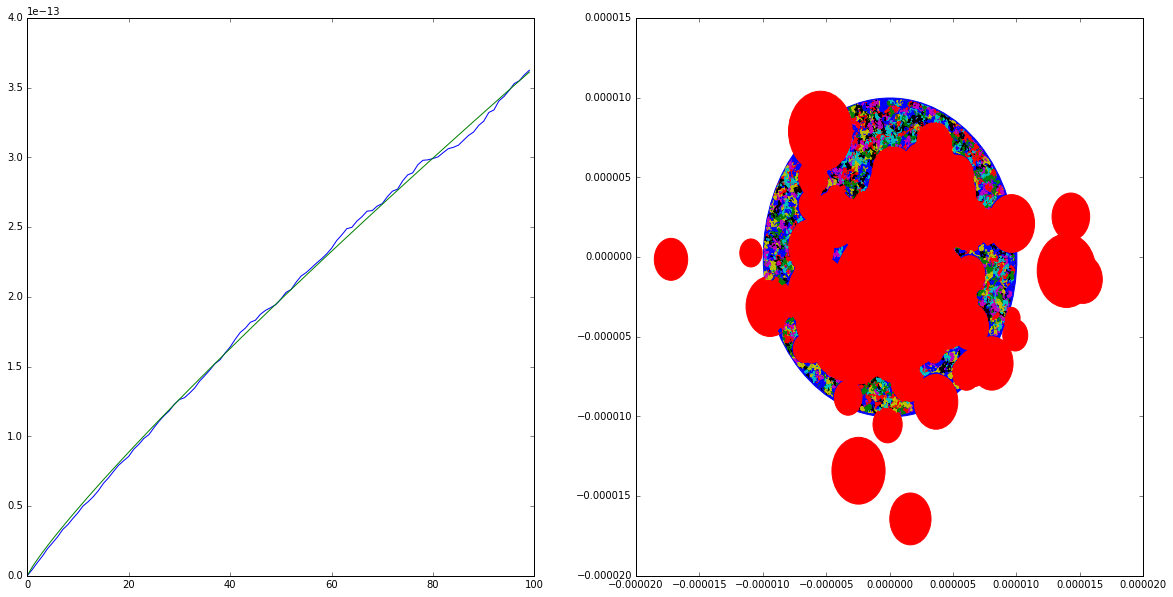

Best fitness: 0.8786003749132472
9


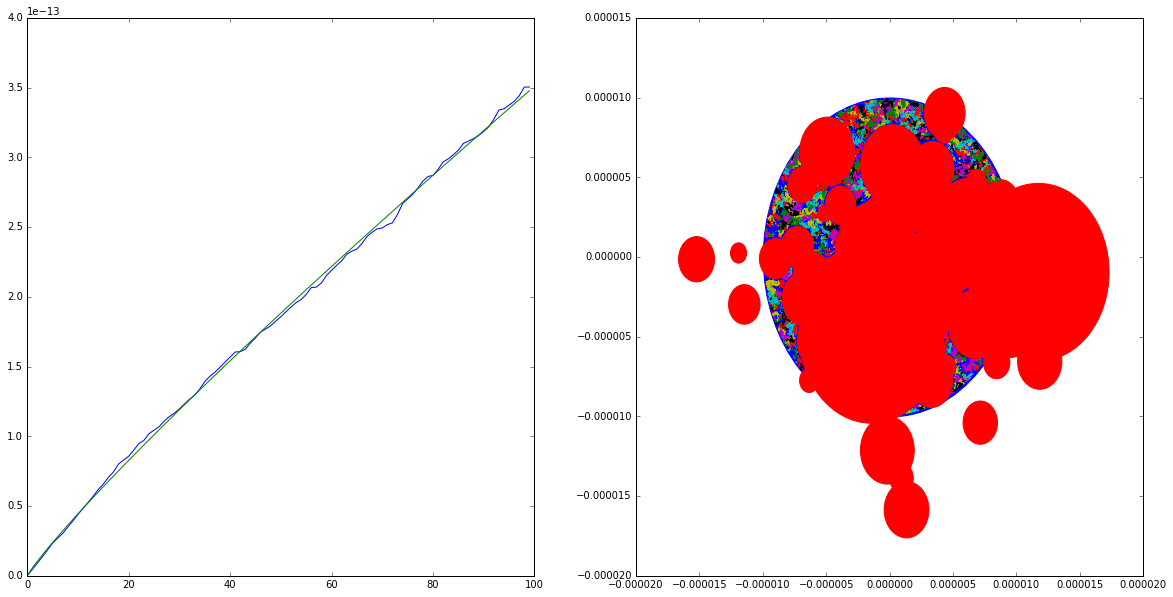

Best fitness: 0.8979041561934417
9


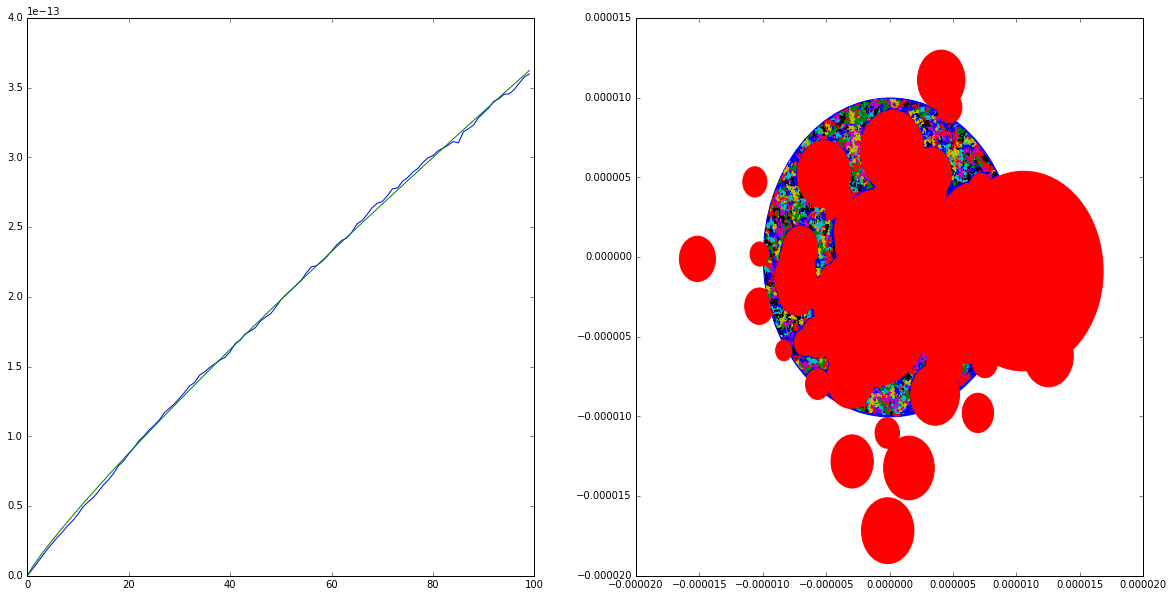

Best fitness: 0.886128978109865
9


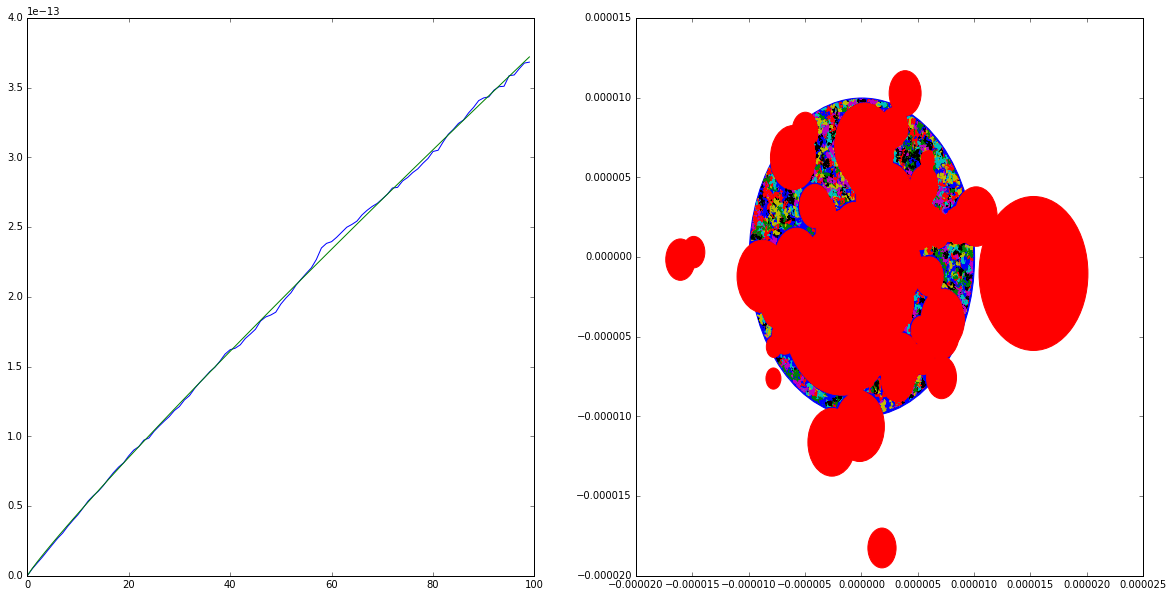

Best fitness: 0.9247128544612394
9


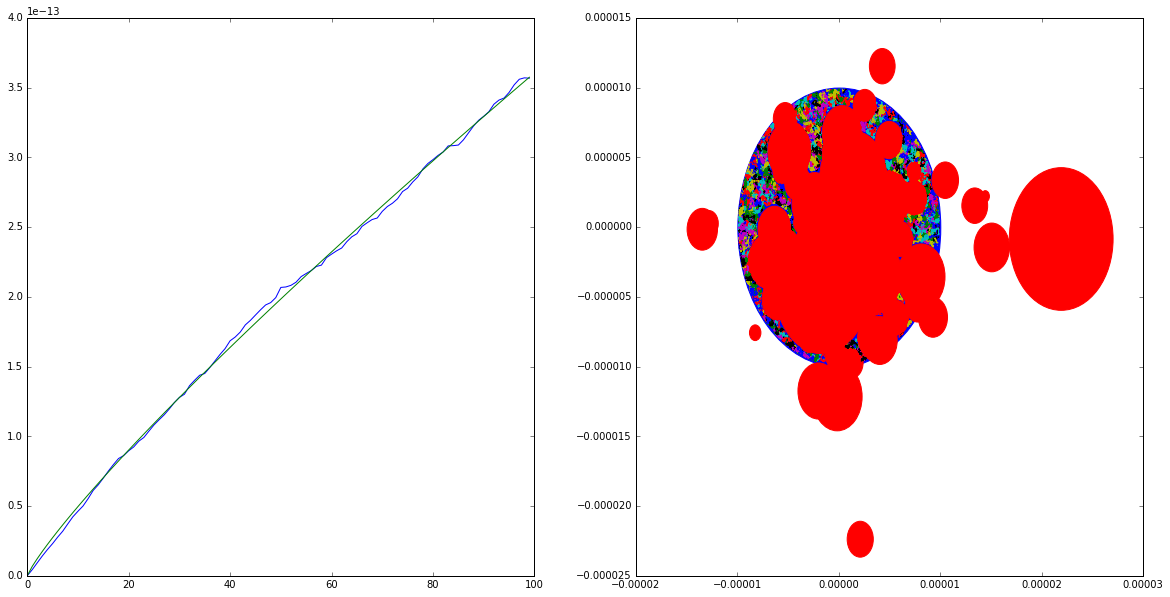

Best fitness: 0.8614579530141142
9


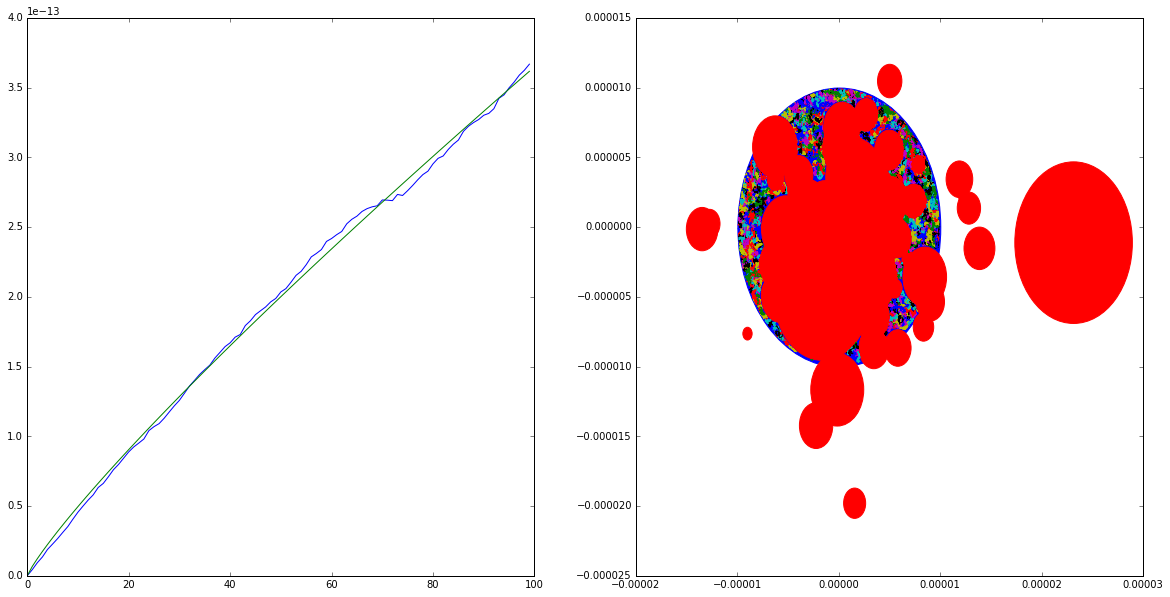

Best fitness: 0.8667083473414476
9


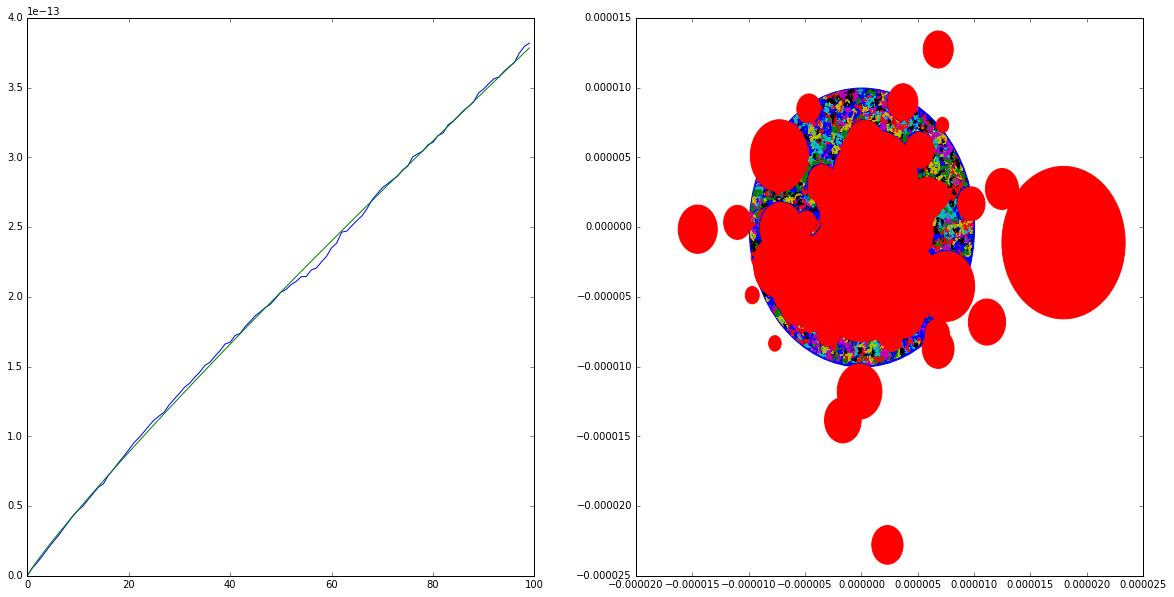

Best fitness: 0.9090331323540105
9


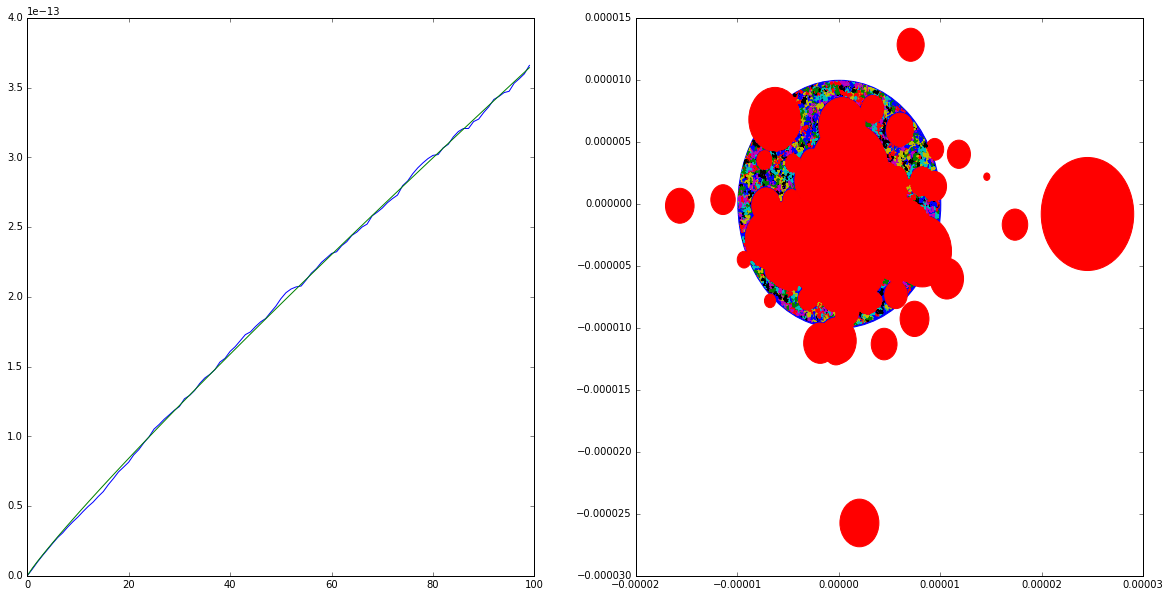

Best fitness: 0.915996856692888
9


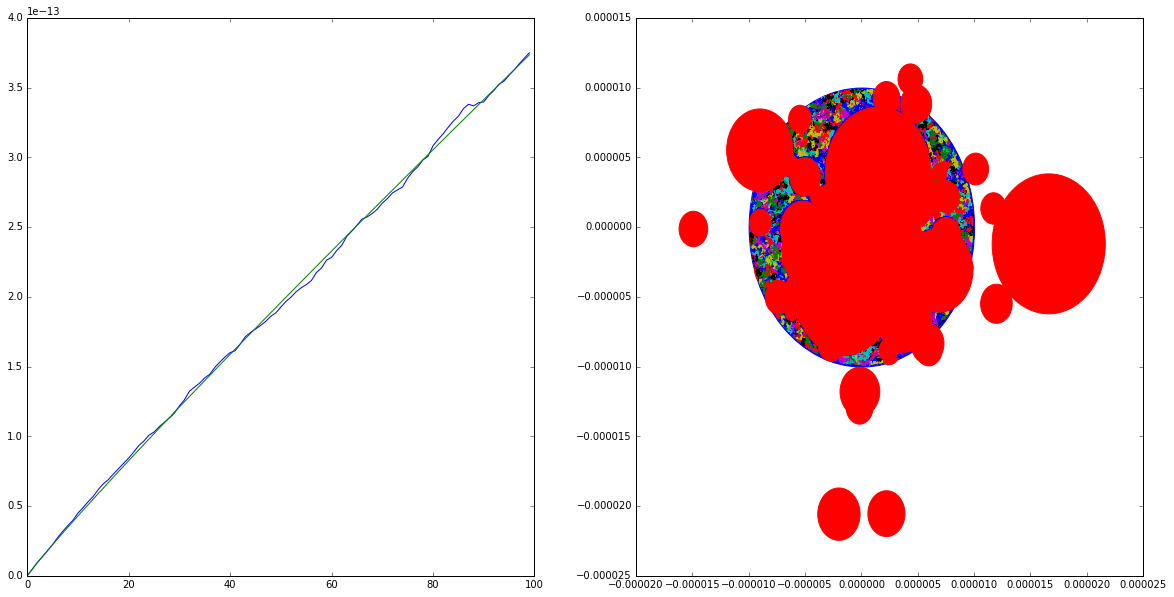

Best fitness: 0.9441649426101643
9


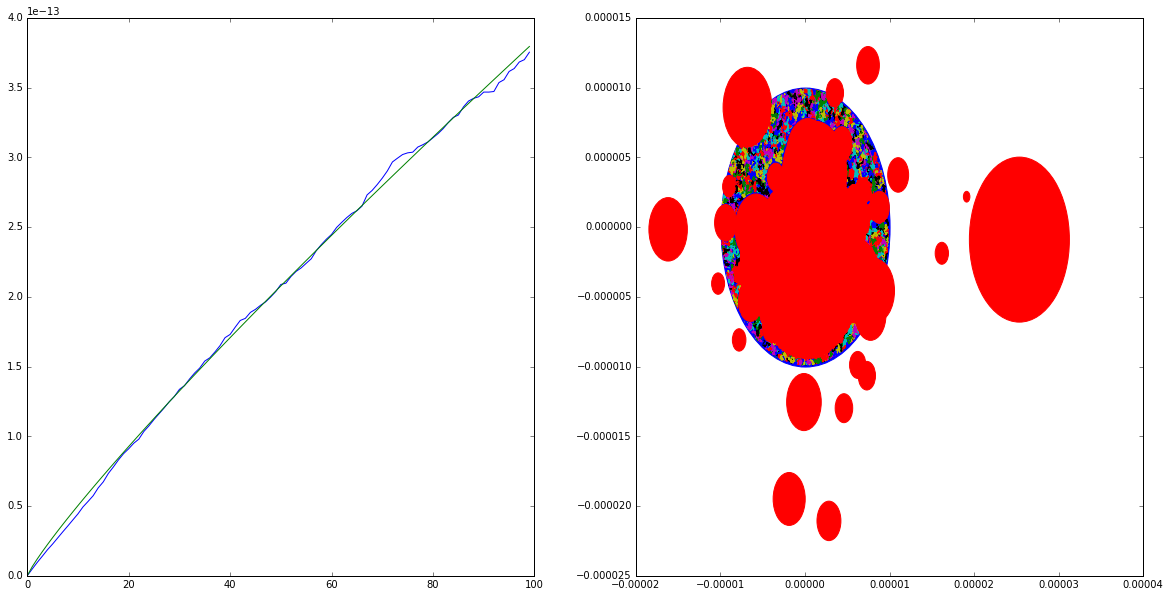

Best fitness: 0.8814066881003678
9


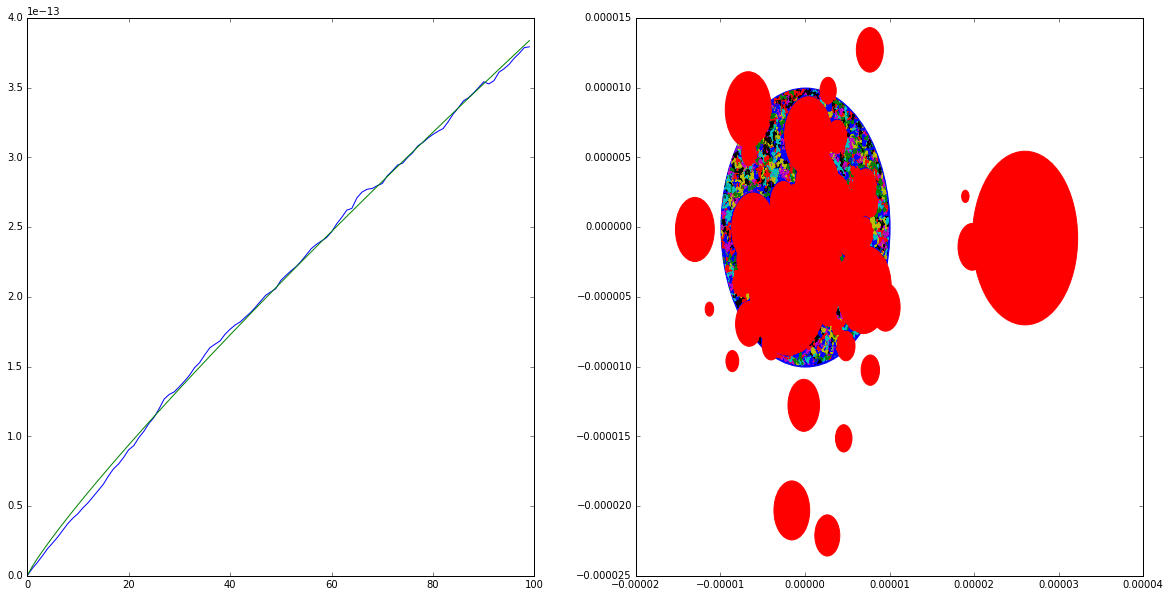

Best fitness: 0.8809486485640889
9


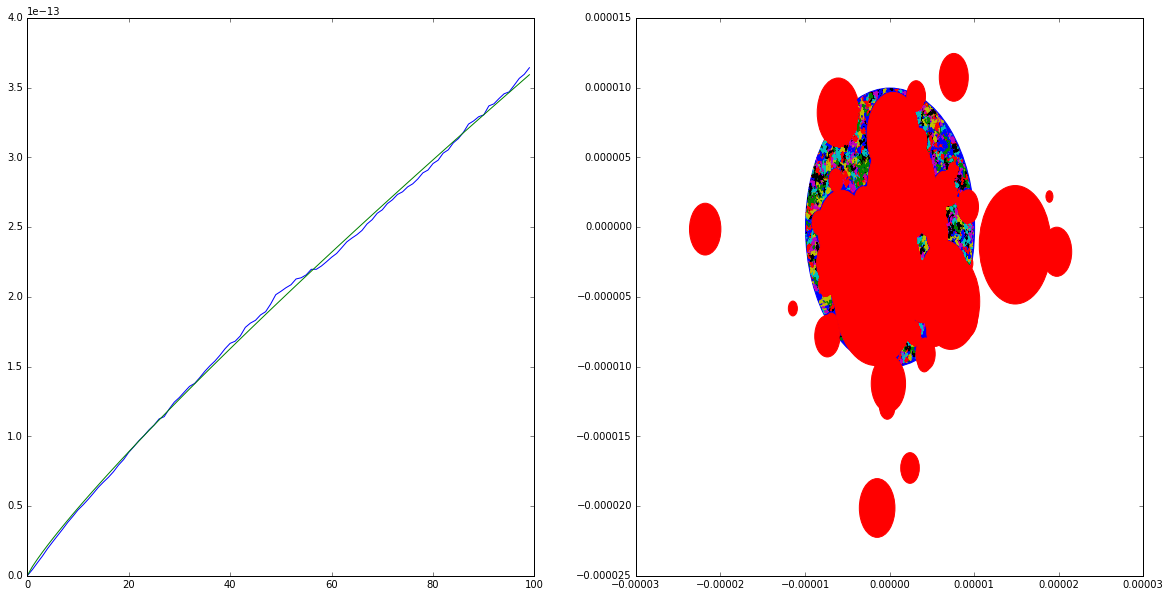

Best fitness: 0.8735846596920108
9


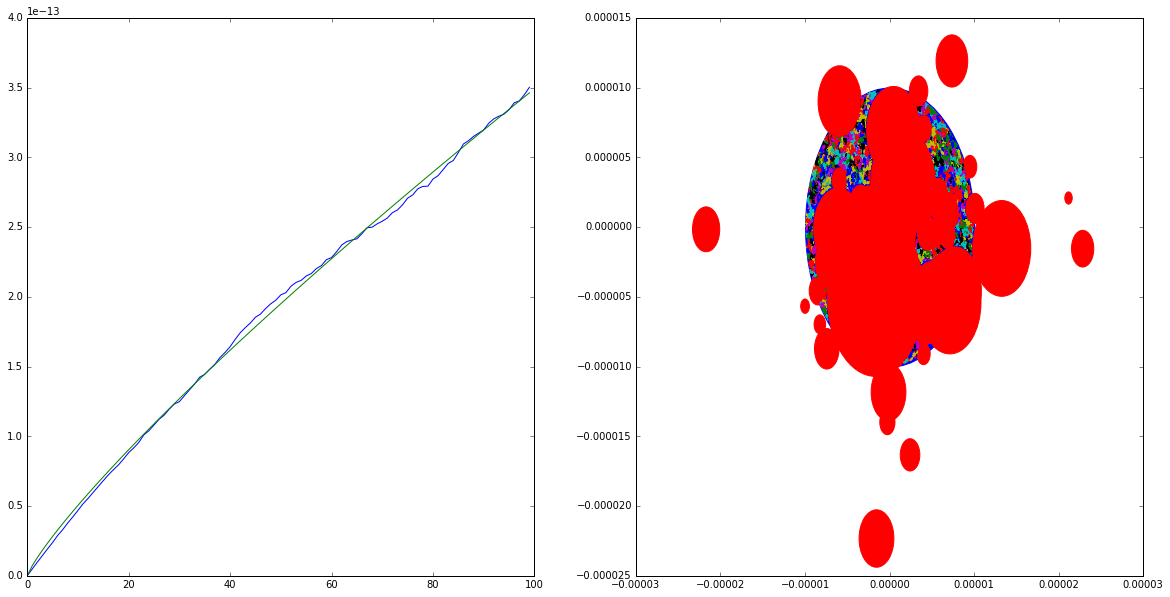

Best fitness: 0.8399943911446367
9


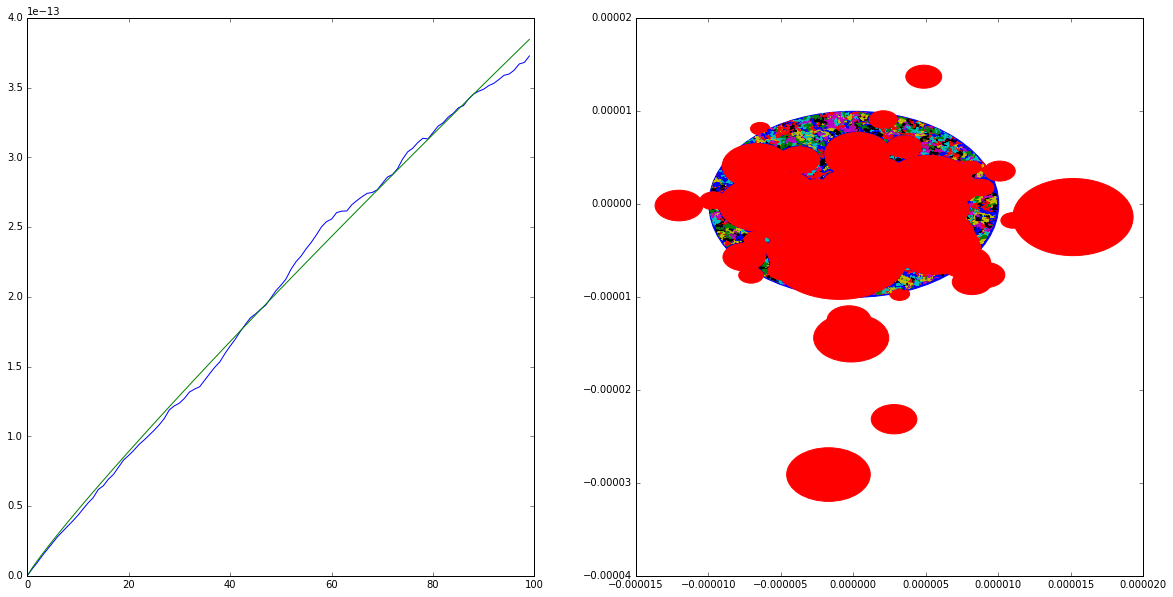

Best fitness: 0.9146118575607397
9


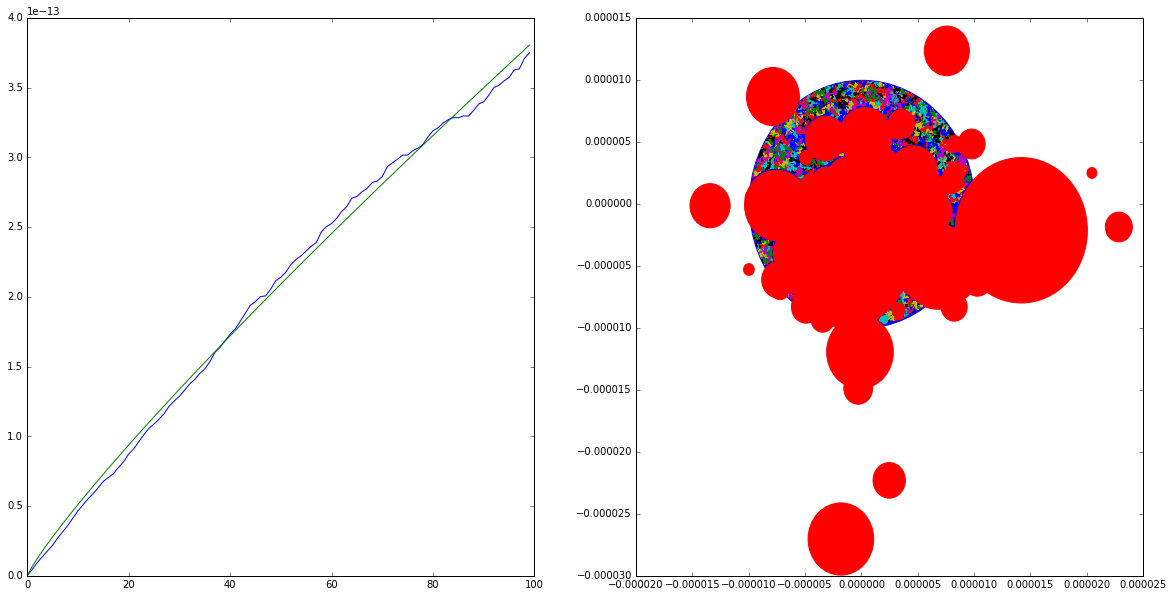

Best fitness: 0.8758841364759716
9


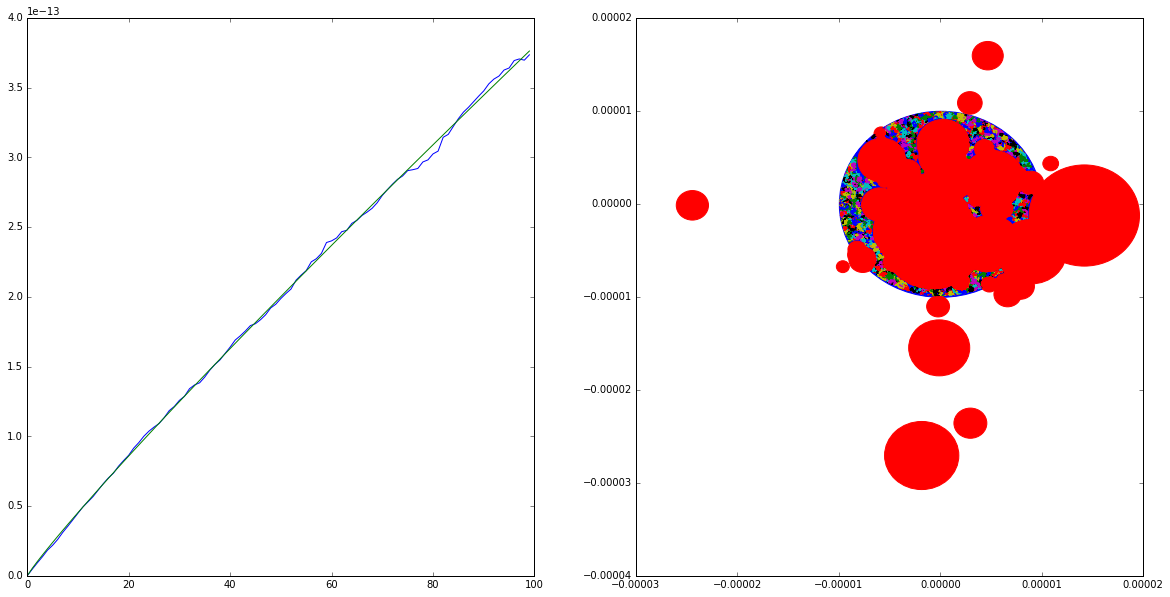

Best fitness: 0.9238029020166226
9


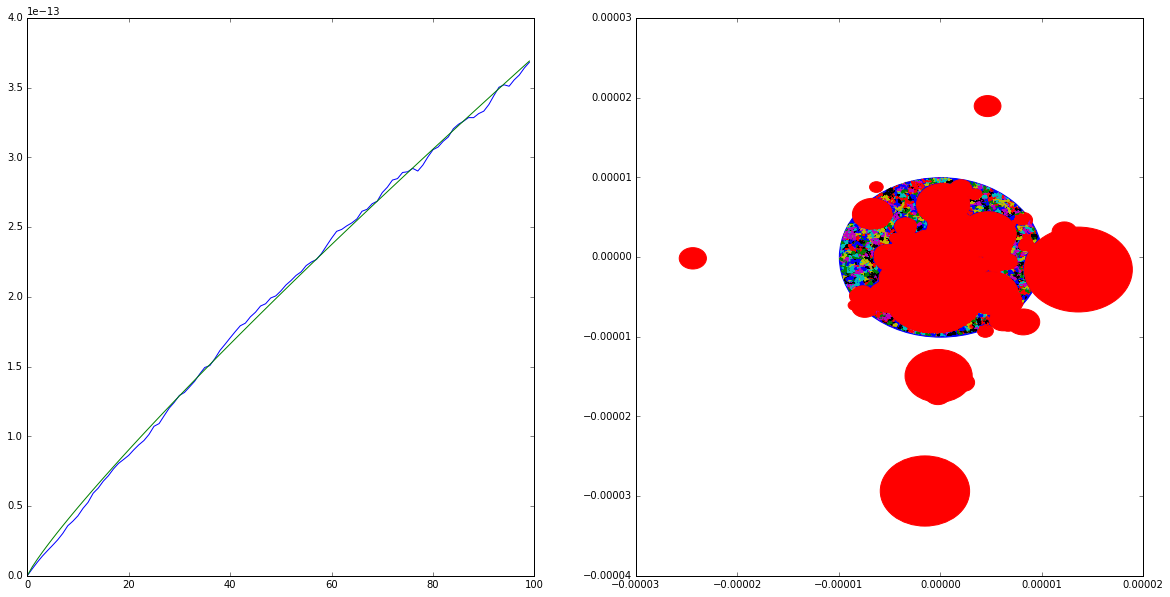

Best fitness: 0.880600638614809
9


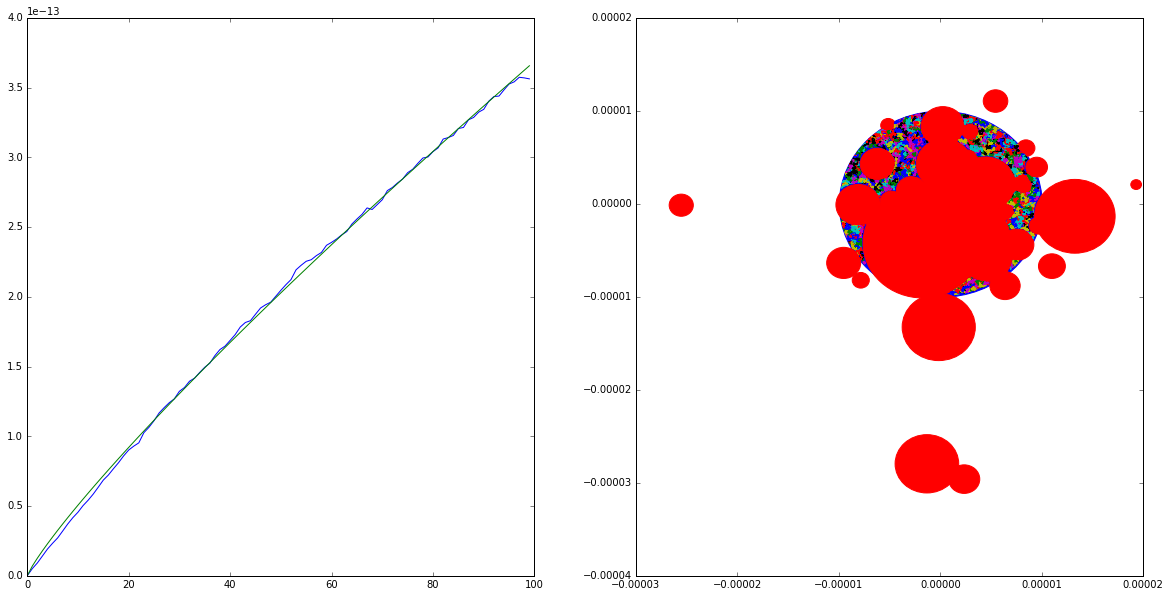

Best fitness: 0.8627672363011205
9


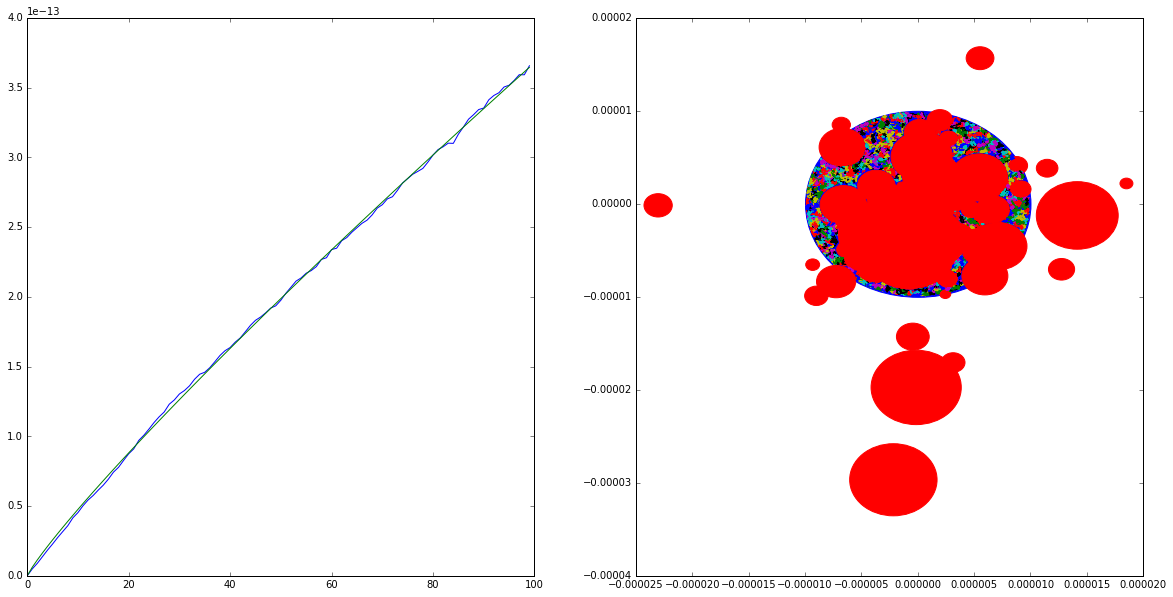

Best fitness: 0.8880409580112157
9


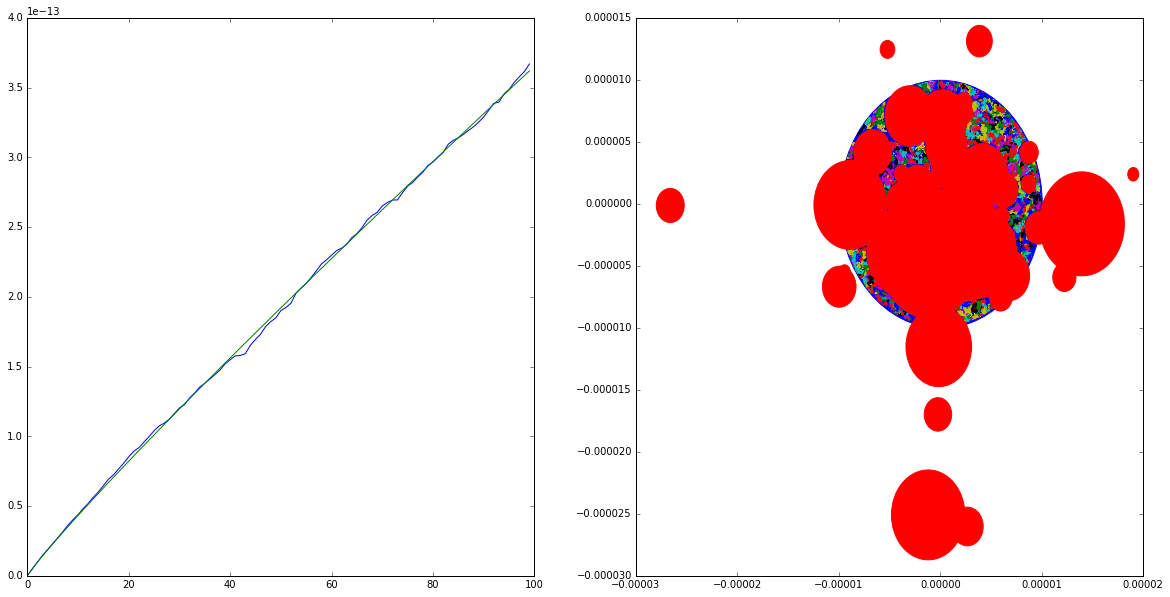

Best fitness: 0.927644024745532
9


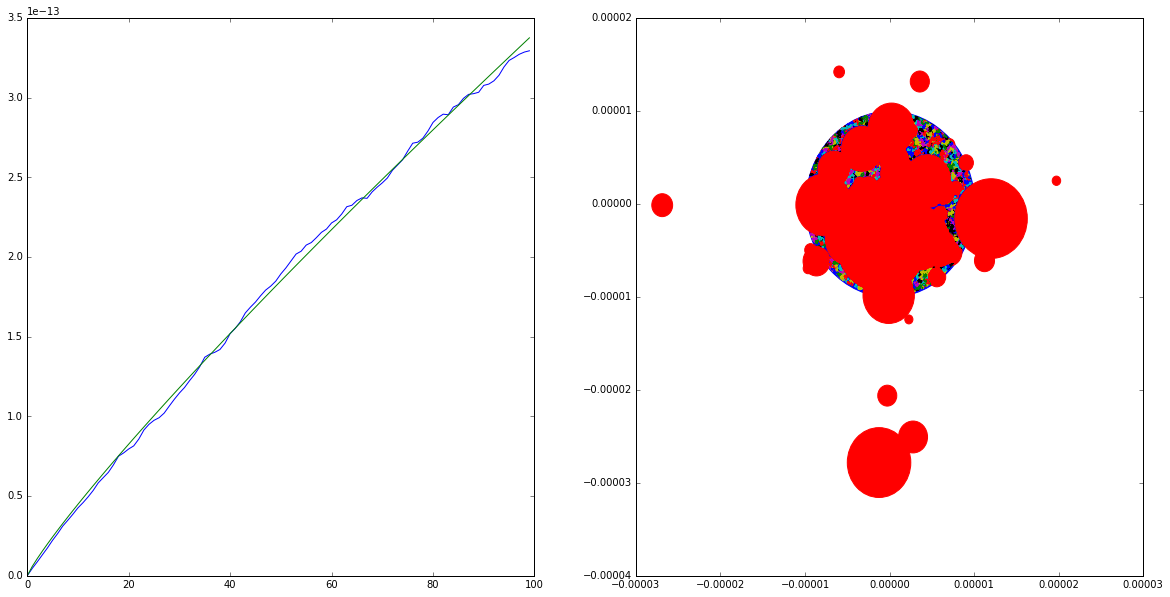

Best fitness: 0.8803077249887032
9


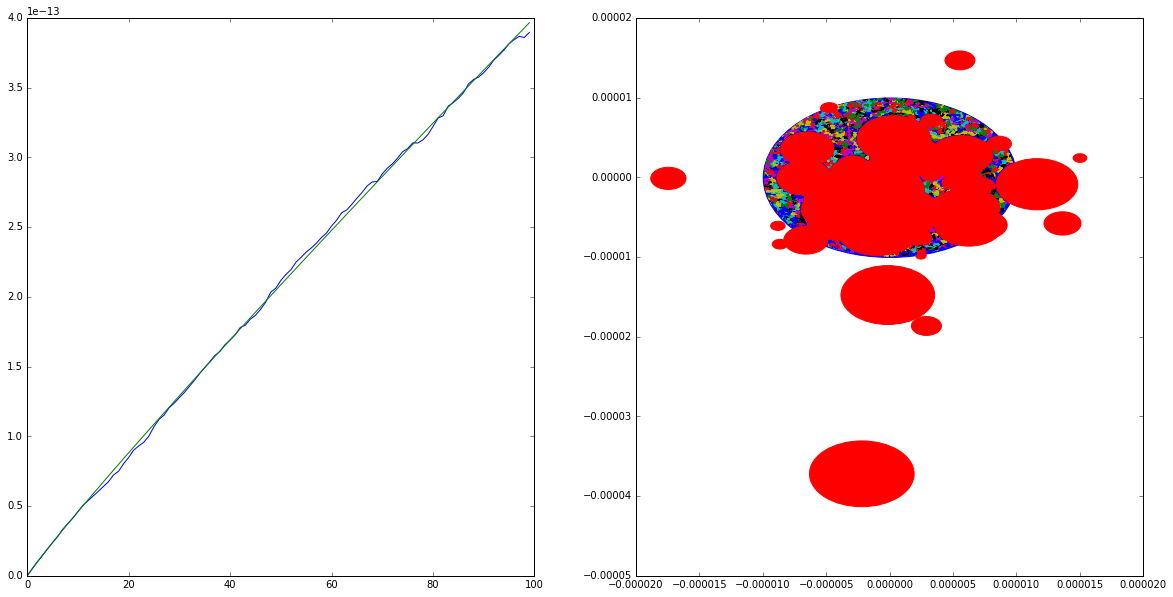

Best fitness: 0.9400511865063973
9


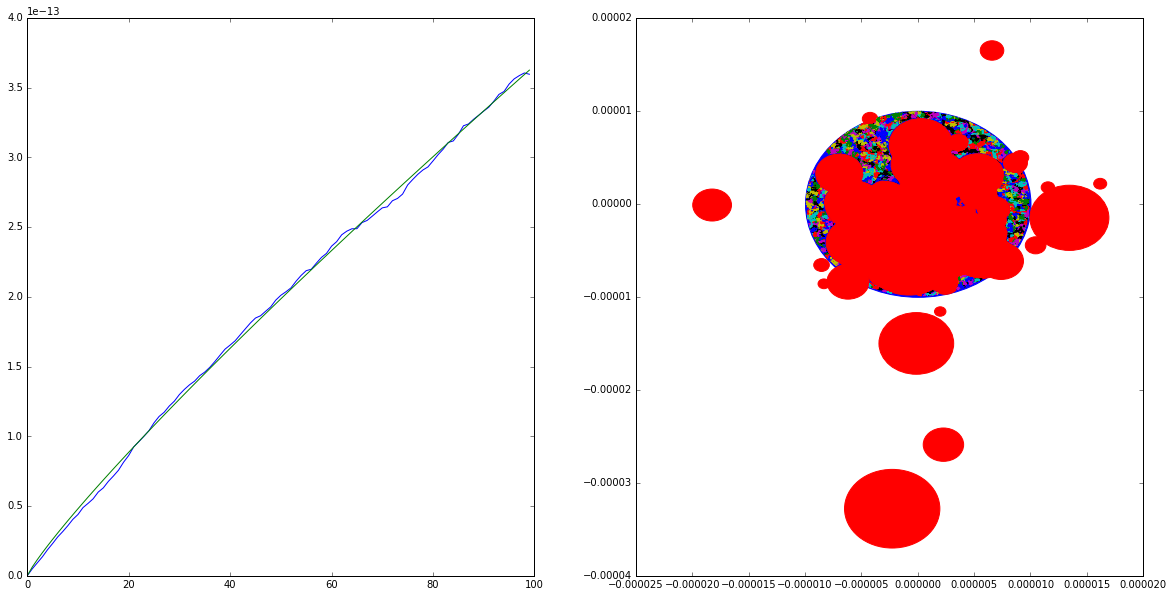

Best fitness: 0.8815793304496258
9


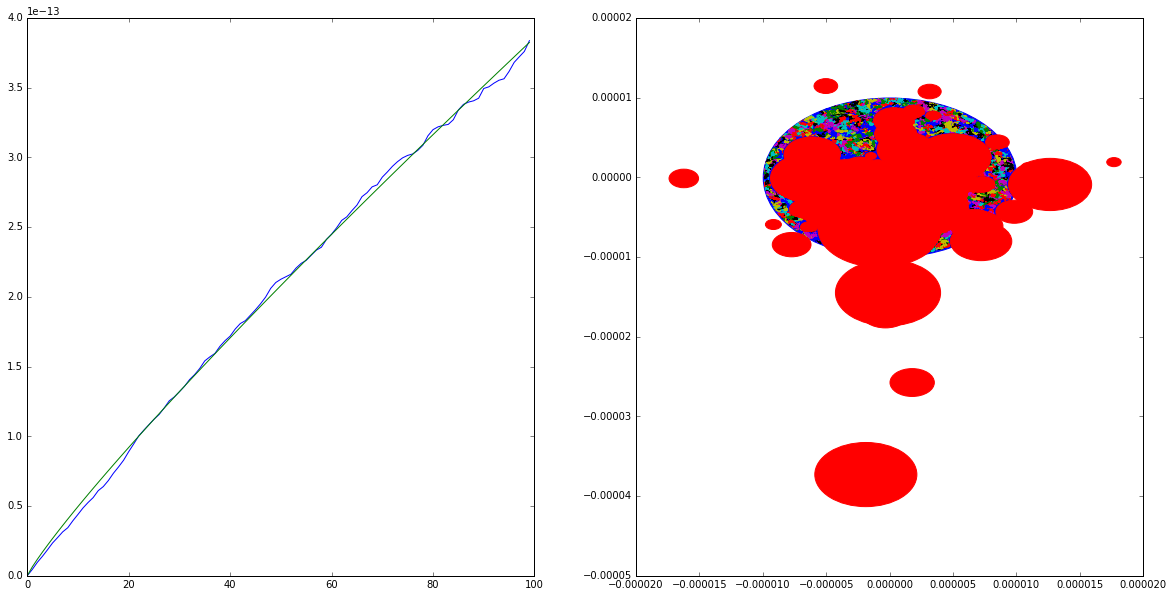

Best fitness: 0.8908547967094819
9


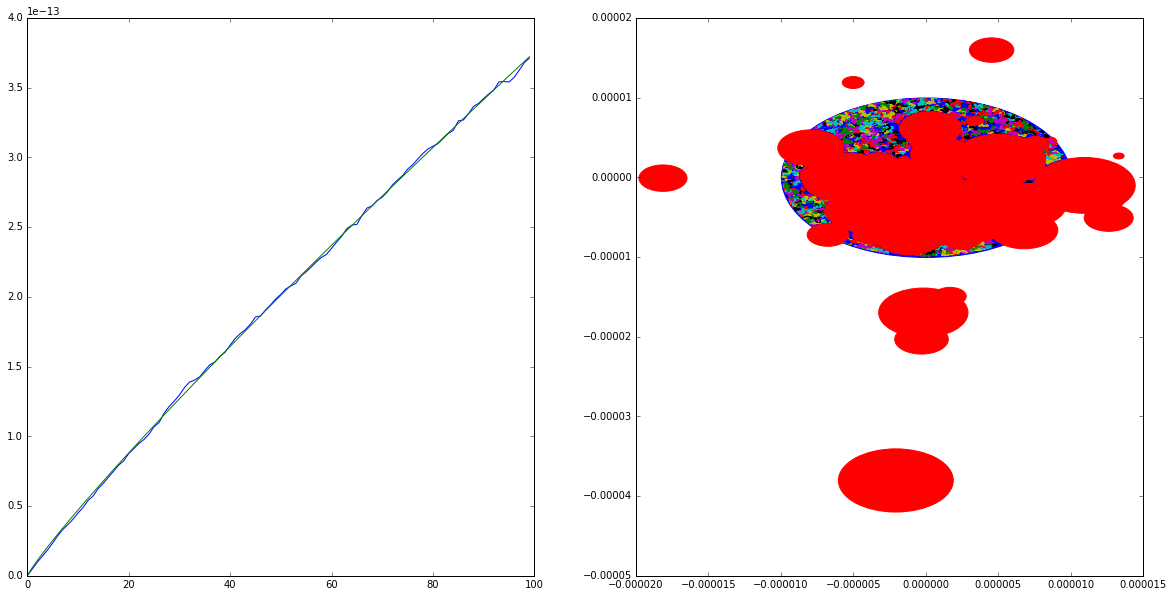

Best fitness: 0.9013459434159218
9


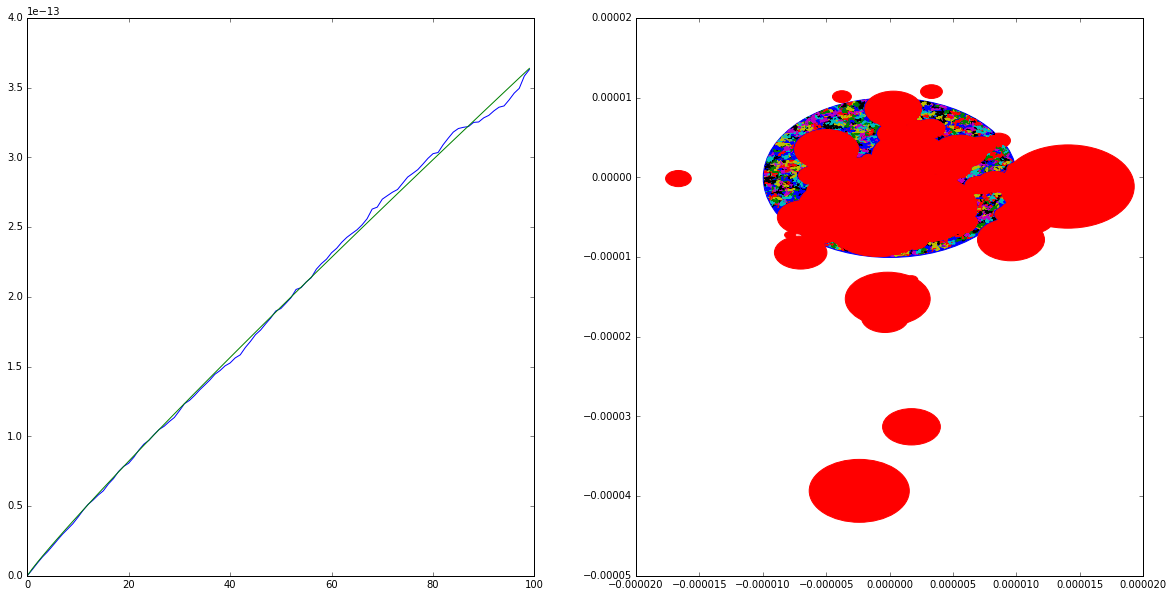

Best fitness: 0.9305123906090801
9


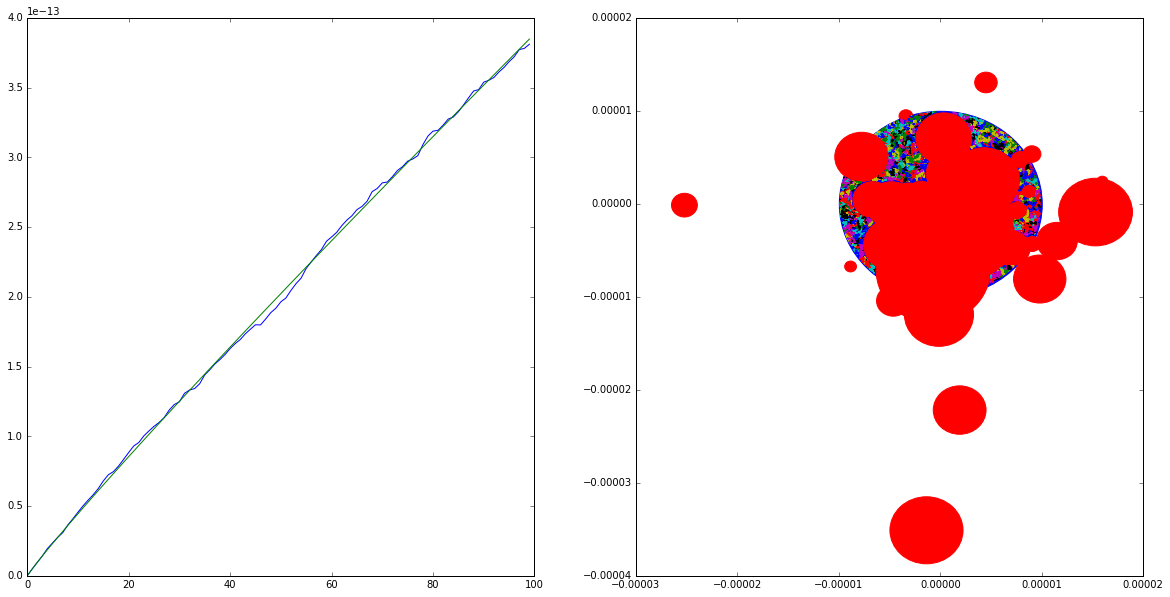

Best fitness: 0.9412502381976698
9


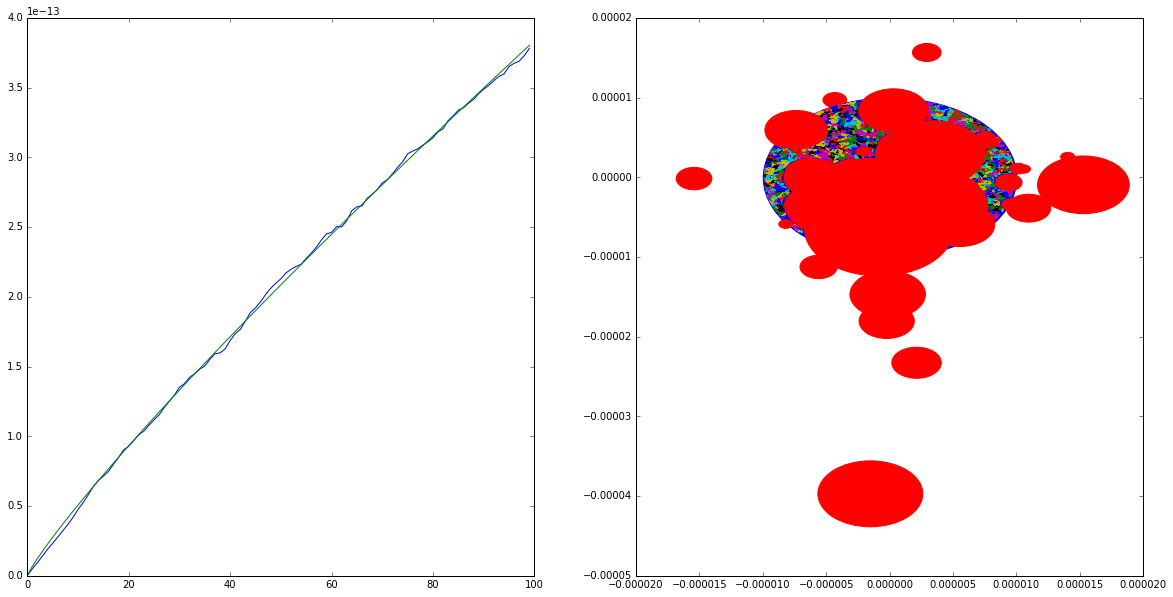

Best fitness: 0.8794698894545364
9


Process ForkPoolWorker-669:
Process ForkPoolWorker-668:
Process ForkPoolWorker-670:
Process ForkPoolWorker-667:
Process ForkPoolWorker-666:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-78-81a42ae5e0a7>", line 13, in calculate_fitness
    tracks = build_tracks(population, obsticles, TRACK_SIZE)
  File "<ipython-input-74-e42cd987ce77>", line 78, in build_tracks
    need_to_revert = np.logical_or(check_for_out_of_bounds(population), filter_collisions(population, obsticles))
  File "<ipython-input-74-e42cd987ce77>", line 66, in filter_collisions
    return 

KeyboardInterrupt: 

In [80]:
def choose(array, indexes):
    return np.multiply(array.T, indexes).T 

def cross(being1, being2):
    indexes = np.random.choice([0, 1], size=being1.shape[0])
    return choose(being1, indexes) + choose(being2, 1 - indexes)

def mutate(being):
    return being * (1 + np.random.randn(*being.shape) * 0.1)

def next_generation(generation):
    return [mutate(cross(being1, being2)) for being1 in generation for being2 in generation]

from multiprocessing import Pool

def sort_with_fitness(generation, fitness_function):
    print(len(generation))
    with Pool(5) as pool:
        fitnesses = pool.map(fitness_function, generation)
    sorted_zipped = sorted(zip(fitnesses, generation), key=itemgetter(0))
    sorted_beings = [being for (fitness, being) in sorted_zipped]
    sorted_fitnessess = [fitness for (fitness, being) in sorted_zipped]
    return sorted_beings, sorted_fitnessess

def norm_ff(being):
    return np.linalg.norm(being)

def square(x):
    return x * x

GEN_SIZE = 3
generation = [generate_points(OBST_CNT, O_MIN_D, O_MAX_D) for i in range(GEN_SIZE)]

while True:
    sorted_generation, sorted_fitnesses = sort_with_fitness(generation, calculate_fitness)
    print('Best fitness: {}'.format(calculate_fitness(sorted_generation[0], True)))    
    generation = next_generation(sorted_generation[:GEN_SIZE])

0.12 0.0426478385925293 to generate 100 population with 100 obsticles
0.35273313522338867 to simulate 100 partitions with 100 obsticles
0.16 0.02587413787841797 to generate 100 population with 100 obsticles
0.3396720886230469 to simulate 100 partitions with 100 obsticles
0.04 0.05355501174926758 to generate 100 population with 100 obsticles
0.33910393714904785 to simulate 100 partitions with 100 obsticles
0.15 0.02209758758544922 to generate 100 population with 100 obsticles
0.34049391746520996 to simulate 100 partitions with 100 obsticles
0.14 0.025279521942138672 to generate 100 population with 100 obsticles
0.3369171619415283 to simulate 100 partitions with 100 obsticles
0.05 0.0448145866394043 to generate 100 population with 100 obsticles
0.3406057357788086 to simulate 100 partitions with 100 obsticles
0.06 0.0390470027923584 to generate 100 population with 100 obsticles
0.3384993076324463 to simulate 100 partitions with 100 obsticles
0.1 0.026777267456054688 to generate 100 popula

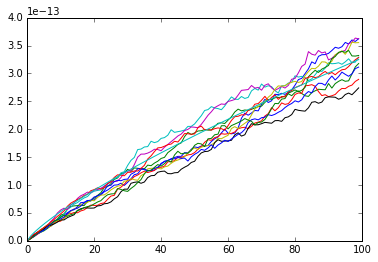

In [61]:
def t_function(x, alpha, beta):
    return beta * x**alpha

for i in range(10):
    start_time = time.time()
    population, obsticles = generate_population_obsticles(100, OBST_CNT)
    end_time = time.time()
    print('{} to generate {} population with {} obsticles'
          .format(end_time - start_time, len(population), len(obsticles)))

    start_time = time.time()
    tracks = build_tracks(population, obsticles, TRACK_SIZE)
    end_time = time.time()
    print('{} to simulate {} partitions with {} obsticles'
      .format(end_time - start_time, len(population), len(obsticles)))
    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) 
              for i in range(0, tracks[0].shape[0])]
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
popt, _ = sp.optimize.curve_fit(t_function, xs, ys, [1, 1])
plt.plot(xs, t_function(xs, *popt))
print(popt)